<a href="https://colab.research.google.com/github/idancz/Gigantic_MuMIMO_ViterbiBasedNet/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gigantic_MuMIMO_ViterbiBasedNet - juypiter notebook format

In [ ]:
#@title setup using git clone
!git clone "https://github.com/idancz/Gigantic_MuMIMO_ViterbiBasedNet.git"
from google.colab import drive
import os
import sys
path = "/content/Gigantic_MuMIMO_ViterbiBasedNet"
%cd $path
%ls -a
# importing all links
def add_directory(curr_dir):
  for dir_name in os.listdir(curr_dir):        
    dir_path = os.path.join(curr_dir, dir_name)   
    if os.path.isdir(dir_path):
      #print("adding directory "+dir_path+"...")
      sys.path.insert(0, dir_path)    
      add_directory(dir_path)
# add all directory to OS path recursively
add_directory("./")

In [ ]:
#@title Executing main.py
from Code.dir_definitions import *
from Code.plotter import get_ser_data, plot_ser_by_block_index, plot_ser_by_snr
from Code.trainer import Trainer

def execute_and_plot(model_name, detector_method, self_supervised, all_curves, current_params, run_over):
    method_name = model_name + "_" + detector_method
    trainer = Trainer(
                    model_name=model_name,
                    detector_method=detector_method,
                    self_supervised=self_supervised,
                    weights_dir=os.path.join(WEIGHTS_DIR,
                    f'{method_name}_training_{HYPERPARAMS_DICT["val_block_length"]}_{HYPERPARAMS_DICT["n_symbols"]}_channel1_{HYPERPARAMS_DICT["channel_coefficients"]}'),
                    **HYPERPARAMS_DICT)

    ser = get_ser_data(trainer, run_over=run_over, method_name=method_name + '_' + current_params)
    all_curves.append((ser, model_name, HYPERPARAMS_DICT['val_block_length'], HYPERPARAMS_DICT['n_symbols']))


HYPERPARAMS_DICT = {
                    'noisy_est_var': 0,
                    'fading_taps_type': 1,  # 1 / 2  for time decay only
                    'fading_in_channel': True,
                    'fading_in_decoder': True,
                    'gamma': 0.2,
                    'channel_type': 'ISI_AWGN',
                    'val_frames': 12,  # up to 12 for cost2100
                    'subframes_in_frame': 25,  # up to 25 for cost2100
                    'self_supervised_iterations': 200,
                    'ser_thresh': 0.02,  # ser threshold for online training
                    'train_minibatch_num': 25,  # 25
                    }


if __name__ == '__main__':
    # main flags
    run_over = 2  # 0 - load plots from previous runs / 1 - load trained weights and start online evaluation / 2 - clear all and start training  from scratch
    plot_by_block = False  # False / True either plot by SNR or by block index
    block_length = 120     # determine the transmission length
    channel_coefficients = 'cost2100'  # 'time_decay' / 'cost2100'
    n_symbol = 2
    snr_start, snr_end = 7, 15

    # deep learning models list 'ADNN', 'Sionna', 'SionnaPlus', 'Transformer', 'LSTM', 'ViterbiNet'
    models_list = ['ADNN', 'Sionna', 'SionnaPlus', 'Transformer', 'LSTM', 'ViterbiNet']
    detector_method = 'ModelBased'  # ModelBased / EndToEnd / Statistical
    self_supervised = True  # True / False for online evaluation enablement

    all_curves = []

    for snr in range(snr_start, snr_end+1):
        print(snr, block_length, n_symbol)

        HYPERPARAMS_DICT['n_symbols'] = n_symbol
        HYPERPARAMS_DICT['curr_SNR'] = snr
        HYPERPARAMS_DICT['val_block_length'] = block_length
        HYPERPARAMS_DICT['train_block_length'] = block_length
        HYPERPARAMS_DICT['fading_in_channel'] = True if channel_coefficients == 'time_decay' else False
        HYPERPARAMS_DICT['channel_coefficients'] = channel_coefficients

        current_params = HYPERPARAMS_DICT['channel_coefficients'] + '_' + str(HYPERPARAMS_DICT['curr_SNR']) + '_' + \
                         str(HYPERPARAMS_DICT['val_block_length']) + '_' + str(HYPERPARAMS_DICT['n_symbols'])

        for model in models_list:
            execute_and_plot(model, detector_method, self_supervised, all_curves, current_params, run_over)

        execute_and_plot('ClassicViterbi', 'Statistical', False, all_curves, current_params, run_over)  # Classic Viterbi Alg with Perfect-CSI

        if plot_by_block:
            plot_ser_by_block_index(all_curves, block_length, n_symbol, snr)

    snr_values = [s for s in range(snr_start, snr_end+1)]
    if not plot_by_block:
        plot_ser_by_snr(all_curves, snr_values)

```
to the last 5000 lines.
Current word: (127, 0.0, 1.0)
***********************************
Current word: (128, 0.0, 1.0)
***********************************
Current word: (129, 0.0, 1.0)
Self-supervised: 130/300, Average SER 0.0
***********************************
Current word: (130, 0.0, 0.0)
***********************************
Current word: (131, 0.0, 0.0)
***********************************
Current word: (132, 0.0, 2.0)
***********************************
Current word: (133, 0.0, 0.0)
***********************************
Current word: (134, 0.0, 1.0)
***********************************
Current word: (135, 0.0, 0.0)
***********************************
Current word: (136, 0.0, 0.0)
***********************************
Current word: (137, 0.0, 0.0)
***********************************
Current word: (138, 0.0, 1.0)
***********************************
Current word: (139, 0.0, 0.0)
Self-supervised: 140/300, Average SER 0.0
***********************************
Current word: (140, 0.0, 0.0)
***********************************
Current word: (141, 0.0, 0.0)
***********************************
Current word: (142, 0.0, 1.0)
***********************************
Current word: (143, 0.0, 3.0)
***********************************
Current word: (144, 0.0, 0.0)
***********************************
Current word: (145, 0.0, 2.0)
***********************************
Current word: (146, 0.0, 0.0)
***********************************
Current word: (147, 0.0, 0.0)
***********************************
Current word: (148, 0.0, 1.0)
***********************************
Current word: (149, 0.0, 1.0)
Self-supervised: 150/300, Average SER 0.0
***********************************
Current word: 150, Pilot
***********************************
Current word: (151, 0.0, 0.0)
***********************************
Current word: (152, 0.0, 0.0)
***********************************
Current word: (153, 0.0, 1.0)
***********************************
Current word: (154, 0.0, 1.0)
***********************************
Current word: (155, 0.0, 1.0)
***********************************
Current word: (156, 0.0, 3.0)
***********************************
Current word: (157, 0.0, 2.0)
***********************************
Current word: (158, 0.0, 1.0)
***********************************
Current word: (159, 0.0, 1.0)
Self-supervised: 160/300, Average SER 0.0
***********************************
Current word: (160, 0.0, 1.0)
***********************************
Current word: (161, 0.0, 0.0)
***********************************
Current word: (162, 0.0, 0.0)
***********************************
Current word: (163, 0.0, 2.0)
***********************************
Current word: (164, 0.0, 1.0)
***********************************
Current word: (165, 0.0, 0.0)
***********************************
Current word: (166, 0.0, 1.0)
***********************************
Current word: (167, 0.0, 2.0)
***********************************
Current word: (168, 0.0, 2.0)
***********************************
Current word: (169, 0.0, 0.0)
Self-supervised: 170/300, Average SER 0.0
***********************************
Current word: (170, 0.0, 2.0)
***********************************
Current word: (171, 0.0, 1.0)
***********************************
Current word: (172, 0.0, 0.0)
***********************************
Current word: (173, 0.0, 1.0)
***********************************
Current word: (174, 0.0, 1.0)
***********************************
Current word: 175, Pilot
***********************************
Current word: (176, 0.0, 2.0)
***********************************
Current word: (177, 0.0, 1.0)
***********************************
Current word: (178, 0.0, 0.0)
***********************************
Current word: (179, 0.0, 2.0)
Self-supervised: 180/300, Average SER 0.0
***********************************
Current word: (180, 0.0, 1.0)
***********************************
Current word: (181, 0.0, 2.0)
***********************************
Current word: (182, 0.0, 1.0)
***********************************
Current word: (183, 0.0, 0.0)
***********************************
Current word: (184, 0.0, 1.0)
***********************************
Current word: (185, 0.0, 1.0)
***********************************
Current word: (186, 0.0, 1.0)
***********************************
Current word: (187, 0.0, 1.0)
***********************************
Current word: (188, 0.0, 2.0)
***********************************
Current word: (189, 0.0, 1.0)
Self-supervised: 190/300, Average SER 0.0
***********************************
Current word: (190, 0.0, 2.0)
***********************************
Current word: (191, 0.0, 0.0)
***********************************
Current word: (192, 0.0, 2.0)
***********************************
Current word: (193, 0.0, 1.0)
***********************************
Current word: (194, 0.0, 1.0)
***********************************
Current word: (195, 0.0, 1.0)
***********************************
Current word: (196, 0.0, 2.0)
***********************************
Current word: (197, 0.0, 3.0)
***********************************
Current word: (198, 0.0, 0.0)
***********************************
Current word: (199, 0.0, 0.0)
Self-supervised: 200/300, Average SER 0.0
***********************************
Current word: 200, Pilot
***********************************
Current word: (201, 0.0, 1.0)
***********************************
Current word: (202, 0.0, 2.0)
***********************************
Current word: (203, 0.0, 1.0)
***********************************
Current word: (204, 0.0, 2.0)
***********************************
Current word: (205, 0.0, 1.0)
***********************************
Current word: (206, 0.0, 3.0)
***********************************
Current word: (207, 0.0, 2.0)
***********************************
Current word: (208, 0.0, 2.0)
***********************************
Current word: (209, 0.0, 1.0)
Self-supervised: 210/300, Average SER 0.0
***********************************
Current word: (210, 0.0, 1.0)
***********************************
Current word: (211, 0.0, 1.0)
***********************************
Current word: (212, 0.0, 0.0)
***********************************
Current word: (213, 0.0, 2.0)
***********************************
Current word: (214, 0.0, 0.0)
***********************************
Current word: (215, 0.0, 1.0)
***********************************
Current word: (216, 0.0, 2.0)
***********************************
Current word: (217, 0.0, 0.0)
***********************************
Current word: (218, 0.0, 1.0)
***********************************
Current word: (219, 0.0, 1.0)
Self-supervised: 220/300, Average SER 0.0
***********************************
Current word: (220, 0.0, 2.0)
***********************************
Current word: (221, 0.0, 0.0)
***********************************
Current word: (222, 0.0, 2.0)
***********************************
Current word: (223, 0.0, 2.0)
***********************************
Current word: (224, 0.0, 1.0)
***********************************
Current word: 225, Pilot
***********************************
Current word: (226, 0.0, 1.0)
***********************************
Current word: (227, 0.0, 0.0)
***********************************
Current word: (228, 0.0, 0.0)
***********************************
Current word: (229, 0.0, 0.0)
Self-supervised: 230/300, Average SER 0.0
***********************************
Current word: (230, 0.0, 0.0)
***********************************
Current word: (231, 0.0, 1.0)
***********************************
Current word: (232, 0.0, 0.0)
***********************************
Current word: (233, 0.0, 1.0)
***********************************
Current word: (234, 0.0, 0.0)
***********************************
Current word: (235, 0.0, 1.0)
***********************************
Current word: (236, 0.0, 1.0)
***********************************
Current word: (237, 0.0, 4.0)
***********************************
Current word: (238, 0.0, 0.0)
***********************************
Current word: (239, 0.0, 1.0)
Self-supervised: 240/300, Average SER 0.0
***********************************
Current word: (240, 0.0, 0.0)
***********************************
Current word: (241, 0.0, 1.0)
***********************************
Current word: (242, 0.0, 1.0)
***********************************
Current word: (243, 0.0, 2.0)
***********************************
Current word: (244, 0.0, 1.0)
***********************************
Current word: (245, 0.0, 2.0)
***********************************
Current word: (246, 0.0, 0.0)
***********************************
Current word: (247, 0.0, 1.0)
***********************************
Current word: (248, 0.0, 1.0)
***********************************
Current word: (249, 0.0, 0.0)
Self-supervised: 250/300, Average SER 0.0
***********************************
Current word: 250, Pilot
***********************************
Current word: (251, 0.0, 1.0)
***********************************
Current word: (252, 0.0, 1.0)
***********************************
Current word: (253, 0.0, 1.0)
***********************************
Current word: (254, 0.0, 0.0)
***********************************
Current word: (255, 0.0, 1.0)
***********************************
Current word: (256, 0.0, 0.0)
***********************************
Current word: (257, 0.0, 1.0)
***********************************
Current word: (258, 0.0, 0.0)
***********************************
Current word: (259, 0.0, 2.0)
Self-supervised: 260/300, Average SER 0.0
***********************************
Current word: (260, 0.0, 0.0)
***********************************
Current word: (261, 0.0, 2.0)
***********************************
Current word: (262, 0.0, 1.0)
***********************************
Current word: (263, 0.0, 0.0)
***********************************
Current word: (264, 0.0, 0.0)
***********************************
Current word: (265, 0.0, 1.0)
***********************************
Current word: (266, 0.0, 2.0)
***********************************
Current word: (267, 0.0, 1.0)
***********************************
Current word: (268, 0.0, 0.0)
***********************************
Current word: (269, 0.0, 1.0)
Self-supervised: 270/300, Average SER 0.0
***********************************
Current word: (270, 0.0, 1.0)
***********************************
Current word: (271, 0.0, 2.0)
***********************************
Current word: (272, 0.0, 0.0)
***********************************
Current word: (273, 0.0, 0.0)
***********************************
Current word: (274, 0.0, 1.0)
***********************************
Current word: 275, Pilot
***********************************
Current word: (276, 0.0, 1.0)
***********************************
Current word: (277, 0.0, 1.0)
***********************************
Current word: (278, 0.0, 1.0)
***********************************
Current word: (279, 0.0, 0.0)
Self-supervised: 280/300, Average SER 0.0
***********************************
Current word: (280, 0.0, 1.0)
***********************************
Current word: (281, 0.0, 1.0)
***********************************
Current word: (282, 0.0, 2.0)
***********************************
Current word: (283, 0.0, 0.0)
***********************************
Current word: (284, 0.0, 1.0)
***********************************
Current word: (285, 0.0, 1.0)
***********************************
Current word: (286, 0.0, 0.0)
***********************************
Current word: (287, 0.0, 0.0)
***********************************
Current word: (288, 0.0, 1.0)
***********************************
Current word: (289, 0.0, 0.0)
Self-supervised: 290/300, Average SER 0.0
***********************************
Current word: (290, 0.0, 2.0)
***********************************
Current word: (291, 0.0, 1.0)
***********************************
Current word: (292, 0.0, 2.0)
***********************************
Current word: (293, 0.0, 0.0)
***********************************
Current word: (294, 0.0, 1.0)
***********************************
Current word: (295, 0.0, 1.0)
***********************************
Current word: (296, 0.0, 2.0)
***********************************
Current word: (297, 0.0, 0.0)
***********************************
Current word: (298, 0.0, 1.0)
***********************************
Current word: (299, 0.0, 1.0)
Self-supervised: 300/300, Average SER 0.0
Final SER: 0.0
0.0
15 120 2
ADNN_ModelBased
ADNN_ModelBased_cost2100_15_120_2
/content/Gigantic_MuMIMO_ViterbiBasedNet/Code/../Results/plots/ADNN_ModelBased_cost2100_15_120_2_ISI_AWGN.pkl
calculating fresh
loading model from SNR 15 and gamma 0.2
Start training SNR - 15, Gamma - 0.2, Channel Cost - cost2100
Minibatch 1 | Train Loss 342.5618870854378 | Validation SER - 0.002199113368988037
Minibatch 2 | Train Loss 110.34850030392408 | Validation SER - 0.0004630088806152344
Minibatch 3 | Train Loss 75.16089268773794 | Validation SER - 0.0002893805503845215
Minibatch 4 | Train Loss 66.39624362811446 | Validation SER - 0.0007812380790710449
Minibatch 5 | Train Loss 67.4024056121707 | Validation SER - 0.00026041269302368164
Minibatch 6 | Train Loss 63.0443276129663 | Validation SER - 0.0004051327705383301
Minibatch 7 | Train Loss 63.194872461259365 | Validation SER - 0.0005497932434082031
Minibatch 8 | Train Loss 59.75665915571153 | Validation SER - 0.0002893805503845215
Minibatch 9 | Train Loss 58.71598573774099 | Validation SER - 0.00037616491317749023
Minibatch 10 | Train Loss 61.8503759521991 | Validation SER - 0.0001157522201538086
Minibatch 11 | Train Loss 56.76062776707113 | Validation SER - 0.0
Minibatch 12 | Train Loss 61.45290917530656 | Validation SER - 0.0001736283302307129
Minibatch 13 | Train Loss 60.37171100452542 | Validation SER - 0.0
Minibatch 14 | Train Loss 57.47838948853314 | Validation SER - 0.00026041269302368164
Minibatch 15 | Train Loss 54.89364631846547 | Validation SER - 0.00031828880310058594
Minibatch 16 | Train Loss 55.93550897948444 | Validation SER - 0.0006655454635620117
Minibatch 17 | Train Loss 52.43553037382662 | Validation SER - 0.00031828880310058594
Minibatch 18 | Train Loss 56.18282599002123 | Validation SER - 0.00031828880310058594
Minibatch 19 | Train Loss 57.849399756640196 | Validation SER - 8.684396743774414e-05
Minibatch 20 | Train Loss 51.102020444348454 | Validation SER - 0.0001157522201538086
Minibatch 21 | Train Loss 57.219303485006094 | Validation SER - 0.0
Minibatch 22 | Train Loss 54.41574049182236 | Validation SER - 0.0004919171333312988
Minibatch 23 | Train Loss 59.2006026301533 | Validation SER - 5.78761100769043e-05
Minibatch 24 | Train Loss 56.61829837784171 | Validation SER - 0.0001157522201538086
Minibatch 25 | Train Loss 53.328711587935686 | Validation SER - 5.78761100769043e-05
Best Validation SER - 0.0 (saved)
**************************************************
Start online evaluation
***********************************
Current word: 0, Pilot
***********************************
Current word: (1, 0.0, 2.0)
***********************************
Current word: (2, 0.0, 1.0)
***********************************
Current word: (3, 0.0, 4.0)
***********************************
Current word: (4, 0.0, 2.0)
***********************************
Current word: (5, 0.0, 3.0)
***********************************
Current word: (6, 0.0, 2.0)
***********************************
Current word: (7, 0.0, 2.0)
***********************************
Current word: (8, 0.0, 4.0)
***********************************
Current word: (9, 0.0, 3.0)
Self-supervised: 10/300, Average SER 0.0
***********************************
Current word: (10, 0.0, 3.0)
***********************************
Current word: (11, 0.0, 2.0)
***********************************
Current word: (12, 0.0, 3.0)
***********************************
Current word: (13, 0.0, 3.0)
***********************************
Current word: (14, 0.0, 4.0)
***********************************
Current word: (15, 0.0, 1.0)
***********************************
Current word: (16, 0.0, 3.0)
***********************************
Current word: (17, 0.0, 0.0)
***********************************
Current word: (18, 0.0, 2.0)
***********************************
Current word: (19, 0.0, 3.0)
Self-supervised: 20/300, Average SER 0.0
***********************************
Current word: (20, 0.0, 3.0)
***********************************
Current word: (21, 0.0, 3.0)
***********************************
Current word: (22, 0.0, 2.0)
***********************************
Current word: (23, 0.0, 2.0)
***********************************
Current word: (24, 0.0, 3.0)
***********************************
Current word: 25, Pilot
***********************************
Current word: (26, 0.0, 3.0)
***********************************
Current word: (27, 0.0, 3.0)
***********************************
Current word: (28, 0.0, 3.0)
***********************************
Current word: (29, 0.0, 1.0)
Self-supervised: 30/300, Average SER 0.0
***********************************
Current word: (30, 0.0, 2.0)
***********************************
Current word: (31, 0.0, 2.0)
***********************************
Current word: (32, 0.0, 1.0)
***********************************
Current word: (33, 0.0, 2.0)
***********************************
Current word: (34, 0.0, 2.0)
***********************************
Current word: (35, 0.0, 2.0)
***********************************
Current word: (36, 0.0, 3.0)
***********************************
Current word: (37, 0.0, 2.0)
***********************************
Current word: (38, 0.0, 4.0)
***********************************
Current word: (39, 0.0, 2.0)
Self-supervised: 40/300, Average SER 0.0
***********************************
Current word: (40, 0.0, 0.0)
***********************************
Current word: (41, 0.0, 2.0)
***********************************
Current word: (42, 0.0, 3.0)
***********************************
Current word: (43, 0.0, 1.0)
***********************************
Current word: (44, 0.0, 0.0)
***********************************
Current word: (45, 0.0, 3.0)
***********************************
Current word: (46, 0.0, 0.0)
***********************************
Current word: (47, 0.0, 2.0)
***********************************
Current word: (48, 0.0, 1.0)
***********************************
Current word: (49, 0.0, 2.0)
Self-supervised: 50/300, Average SER 0.0
***********************************
Current word: 50, Pilot
***********************************
Current word: (51, 0.0, 3.0)
***********************************
Current word: (52, 0.0, 2.0)
***********************************
Current word: (53, 0.0, 2.0)
***********************************
Current word: (54, 0.0, 4.0)
***********************************
Current word: (55, 0.0, 2.0)
***********************************
Current word: (56, 0.0, 2.0)
***********************************
Current word: (57, 0.0, 1.0)
***********************************
Current word: (58, 0.0, 0.0)
***********************************
Current word: (59, 0.0, 2.0)
Self-supervised: 60/300, Average SER 0.0
***********************************
Current word: (60, 0.0, 3.0)
***********************************
Current word: (61, 0.0, 1.0)
***********************************
Current word: (62, 0.0, 2.0)
***********************************
Current word: (63, 0.0, 3.0)
***********************************
Current word: (64, 0.0, 3.0)
***********************************
Current word: (65, 0.0, 0.0)
***********************************
Current word: (66, 0.0, 2.0)
***********************************
Current word: (67, 0.0, 2.0)
***********************************
Current word: (68, 0.0, 1.0)
***********************************
Current word: (69, 0.0, 3.0)
Self-supervised: 70/300, Average SER 0.0
***********************************
Current word: (70, 0.0, 3.0)
***********************************
Current word: (71, 0.0, 2.0)
***********************************
Current word: (72, 0.0, 1.0)
***********************************
Current word: (73, 0.0, 1.0)
***********************************
Current word: (74, 0.0, 1.0)
***********************************
Current word: 75, Pilot
***********************************
Current word: (76, 0.0, 2.0)
***********************************
Current word: (77, 0.0, 1.0)
***********************************
Current word: (78, 0.0, 3.0)
***********************************
Current word: (79, 0.0, 2.0)
Self-supervised: 80/300, Average SER 0.0
***********************************
Current word: (80, 0.0, 2.0)
***********************************
Current word: (81, 0.0, 2.0)
***********************************
Current word: (82, 0.0, 2.0)
***********************************
Current word: (83, 0.0, 3.0)
***********************************
Current word: (84, 0.0, 3.0)
***********************************
Current word: (85, 0.0, 2.0)
***********************************
Current word: (86, 0.0, 1.0)
***********************************
Current word: (87, 0.0, 2.0)
***********************************
Current word: (88, 0.0, 1.0)
***********************************
Current word: (89, 0.0, 2.0)
Self-supervised: 90/300, Average SER 0.0
***********************************
Current word: (90, 0.0, 1.0)
***********************************
Current word: (91, 0.0, 1.0)
***********************************
Current word: (92, 0.0, 1.0)
***********************************
Current word: (93, 0.0, 1.0)
***********************************
Current word: (94, 0.0, 2.0)
***********************************
Current word: (95, 0.0, 1.0)
***********************************
Current word: (96, 0.0, 2.0)
***********************************
Current word: (97, 0.0, 2.0)
***********************************
Current word: (98, 0.0, 0.0)
***********************************
Current word: (99, 0.0, 3.0)
Self-supervised: 100/300, Average SER 0.0
***********************************
Current word: 100, Pilot
***********************************
Current word: (101, 0.0, 1.0)
***********************************
Current word: (102, 0.0, 3.0)
***********************************
Current word: (103, 0.0, 3.0)
***********************************
Current word: (104, 0.0, 1.0)
***********************************
Current word: (105, 0.0, 3.0)
***********************************
Current word: (106, 0.0, 3.0)
***********************************
Current word: (107, 0.0, 1.0)
***********************************
Current word: (108, 0.0, 0.0)
***********************************
Current word: (109, 0.0, 3.0)
Self-supervised: 110/300, Average SER 0.0
***********************************
Current word: (110, 0.0, 1.0)
***********************************
Current word: (111, 0.0, 2.0)
***********************************
Current word: (112, 0.0, 2.0)
***********************************
Current word: (113, 0.0, 2.0)
***********************************
Current word: (114, 0.0, 1.0)
***********************************
Current word: (115, 0.0, 2.0)
***********************************
Current word: (116, 0.0, 1.0)
***********************************
Current word: (117, 0.0, 4.0)
***********************************
Current word: (118, 0.0, 0.0)
***********************************
Current word: (119, 0.0, 3.0)
Self-supervised: 120/300, Average SER 0.0
***********************************
Current word: (120, 0.0, 2.0)
***********************************
Current word: (121, 0.0, 2.0)
***********************************
Current word: (122, 0.0, 2.0)
***********************************
Current word: (123, 0.0, 4.0)
***********************************
Current word: (124, 0.0, 3.0)
***********************************
Current word: 125, Pilot
***********************************
Current word: (126, 0.0, 1.0)
***********************************
Current word: (127, 0.0, 1.0)
***********************************
Current word: (128, 0.0, 3.0)
***********************************
Current word: (129, 0.0, 2.0)
Self-supervised: 130/300, Average SER 0.0
***********************************
Current word: (130, 0.0, 2.0)
***********************************
Current word: (131, 0.0, 2.0)
***********************************
Current word: (132, 0.0, 3.0)
***********************************
Current word: (133, 0.0, 2.0)
***********************************
Current word: (134, 0.0, 4.0)
***********************************
Current word: (135, 0.0, 3.0)
***********************************
Current word: (136, 0.0, 3.0)
***********************************
Current word: (137, 0.0, 2.0)
***********************************
Current word: (138, 0.0, 2.0)
***********************************
Current word: (139, 0.0, 0.0)
Self-supervised: 140/300, Average SER 0.0
***********************************
Current word: (140, 0.0, 1.0)
***********************************
Current word: (141, 0.0, 3.0)
***********************************
Current word: (142, 0.0, 2.0)
***********************************
Current word: (143, 0.0, 3.0)
***********************************
Current word: (144, 0.0, 2.0)
***********************************
Current word: (145, 0.0, 2.0)
***********************************
Current word: (146, 0.0, 3.0)
***********************************
Current word: (147, 0.0, 3.0)
***********************************
Current word: (148, 0.0, 1.0)
***********************************
Current word: (149, 0.0, 2.0)
Self-supervised: 150/300, Average SER 0.0
***********************************
Current word: 150, Pilot
***********************************
Current word: (151, 0.03333330154418945, 10.0)
***********************************
Current word: (152, 0.0, 1.0)
***********************************
Current word: (153, 0.0, 3.0)
***********************************
Current word: (154, 0.0, 2.0)
***********************************
Current word: (155, 0.0, 2.0)
***********************************
Current word: (156, 0.0, 1.0)
***********************************
Current word: (157, 0.0, 0.0)
***********************************
Current word: (158, 0.0, 1.0)
***********************************
Current word: (159, 0.0, 2.0)
Self-supervised: 160/300, Average SER 0.00020833313465118408
***********************************
Current word: (160, 0.0, 2.0)
***********************************
Current word: (161, 0.0, 1.0)
***********************************
Current word: (162, 0.0, 2.0)
***********************************
Current word: (163, 0.0, 1.0)
***********************************
Current word: (164, 0.0, 2.0)
***********************************
Current word: (165, 0.0, 0.0)
***********************************
Current word: (166, 0.0, 2.0)
***********************************
Current word: (167, 0.0, 1.0)
***********************************
Current word: (168, 0.0, 3.0)
***********************************
Current word: (169, 0.0, 2.0)
Self-supervised: 170/300, Average SER 0.000196078244377585
***********************************
Current word: (170, 0.0, 1.0)
***********************************
Current word: (171, 0.0, 2.0)
***********************************
Current word: (172, 0.0, 3.0)
***********************************
Current word: (173, 0.0, 2.0)
***********************************
Current word: (174, 0.0, 2.0)
***********************************
Current word: 175, Pilot
***********************************
Current word: (176, 0.0, 3.0)
***********************************
Current word: (177, 0.0, 2.0)
***********************************
Current word: (178, 0.0, 2.0)
***********************************
Current word: (179, 0.0, 1.0)
Self-supervised: 180/300, Average SER 0.00018518500857883028
***********************************
Current word: (180, 0.0, 2.0)
***********************************
Current word: (181, 0.0, 2.0)
***********************************
Current word: (182, 0.0, 3.0)
***********************************
Current word: (183, 0.0, 1.0)
***********************************
Current word: (184, 0.0, 2.0)
***********************************
Current word: (185, 0.0, 2.0)
***********************************
Current word: (186, 0.0, 4.0)
***********************************
Current word: (187, 0.0, 1.0)
***********************************
Current word: (188, 0.0, 1.0)
***********************************
Current word: (189, 0.0, 2.0)
Self-supervised: 190/300, Average SER 0.0001754384291799445
***********************************
Current word: (190, 0.0, 2.0)
***********************************
Current word: (191, 0.0, 3.0)
***********************************
Current word: (192, 0.0, 2.0)
***********************************
Current word: (193, 0.0, 2.0)
***********************************
Current word: (194, 0.0, 1.0)
***********************************
Current word: (195, 0.0, 2.0)
***********************************
Current word: (196, 0.0, 3.0)
***********************************
Current word: (197, 0.0, 1.0)
***********************************
Current word: (198, 0.0, 2.0)
***********************************
Current word: (199, 0.0, 1.0)
Self-supervised: 200/300, Average SER 0.00016666650772094725
***********************************
Current word: 200, Pilot
***********************************
Current word: (201, 0.0, 2.0)
***********************************
Current word: (202, 0.0, 2.0)
***********************************
Current word: (203, 0.0, 1.0)
***********************************
Current word: (204, 0.0, 3.0)
***********************************
Current word: (205, 0.0, 3.0)
***********************************
Current word: (206, 0.0, 2.0)
***********************************
Current word: (207, 0.0, 3.0)
***********************************
Current word: (208, 0.0, 3.0)
***********************************
Current word: (209, 0.0, 2.0)
Self-supervised: 210/300, Average SER 0.00015873000735328312
***********************************
Current word: (210, 0.0, 3.0)
***********************************
Current word: (211, 0.0, 1.0)
***********************************
Current word: (212, 0.0, 2.0)
***********************************
Current word: (213, 0.0, 2.0)
***********************************
Current word: (214, 0.0, 2.0)
***********************************
Current word: (215, 0.0, 4.0)
***********************************
Current word: (216, 0.0, 1.0)
***********************************
Current word: (217, 0.0, 2.0)
***********************************
Current word: (218, 0.0, 2.0)
***********************************
Current word: (219, 0.0, 4.0)
Self-supervised: 220/300, Average SER 0.00015151500701904297
***********************************
Current word: (220, 0.0, 4.0)
***********************************
Current word: (221, 0.0, 2.0)
***********************************
Current word: (222, 0.0, 1.0)
***********************************
Current word: (223, 0.0, 4.0)
***********************************
Current word: (224, 0.0, 2.0)
***********************************
Current word: 225, Pilot
***********************************
Current word: (226, 0.0, 4.0)
***********************************
Current word: (227, 0.0, 2.0)
***********************************
Current word: (228, 0.0, 2.0)
***********************************
Current word: (229, 0.0, 0.0)
Self-supervised: 230/300, Average SER 0.000144927398018215
***********************************
Current word: (230, 0.0, 0.0)
***********************************
Current word: (231, 0.0, 3.0)
***********************************
Current word: (232, 0.0, 1.0)
***********************************
Current word: (233, 0.0, 4.0)
***********************************
Current word: (234, 0.0, 1.0)
***********************************
Current word: (235, 0.0, 0.0)
***********************************
Current word: (236, 0.0, 2.0)
***********************************
Current word: (237, 0.0, 3.0)
***********************************
Current word: (238, 0.0, 2.0)
***********************************
Current word: (239, 0.0, 1.0)
Self-supervised: 240/300, Average SER 0.0001388887564341227
***********************************
Current word: (240, 0.0, 2.0)
***********************************
Current word: (241, 0.0, 2.0)
***********************************
Current word: (242, 0.0, 2.0)
***********************************
Current word: (243, 0.0, 2.0)
***********************************
Current word: (244, 0.0, 4.0)
***********************************
Current word: (245, 0.0, 3.0)
***********************************
Current word: (246, 0.0, 3.0)
***********************************
Current word: (247, 0.0, 2.0)
***********************************
Current word: (248, 0.0, 1.0)
***********************************
Current word: (249, 0.0, 2.0)
Self-supervised: 250/300, Average SER 0.00013333320617675781
***********************************
Current word: 250, Pilot
***********************************
Current word: (251, 0.0, 1.0)
***********************************
Current word: (252, 0.0, 1.0)
***********************************
Current word: (253, 0.0, 1.0)
***********************************
Current word: (254, 0.0, 2.0)
***********************************
Current word: (255, 0.0, 2.0)
***********************************
Current word: (256, 0.0, 0.0)
***********************************
Current word: (257, 0.0, 2.0)
***********************************
Current word: (258, 0.0, 3.0)
***********************************
Current word: (259, 0.0, 2.0)
Self-supervised: 260/300, Average SER 0.00012820500593919022
***********************************
Current word: (260, 0.0, 1.0)
***********************************
Current word: (261, 0.0, 1.0)
***********************************
Current word: (262, 0.0, 4.0)
***********************************
Current word: (263, 0.0, 0.0)
***********************************
Current word: (264, 0.0, 3.0)
***********************************
Current word: (265, 0.0, 0.0)
***********************************
Current word: (266, 0.0, 3.0)
***********************************
Current word: (267, 0.0, 2.0)
***********************************
Current word: (268, 0.0, 2.0)
***********************************
Current word: (269, 0.0, 3.0)
Self-supervised: 270/300, Average SER 0.00012345667238588686
***********************************
Current word: (270, 0.0, 3.0)
***********************************
Current word: (271, 0.0, 1.0)
***********************************
Current word: (272, 0.0, 2.0)
***********************************
Current word: (273, 0.0, 3.0)
***********************************
Current word: (274, 0.0, 3.0)
***********************************
Current word: 275, Pilot
***********************************
Current word: (276, 0.0, 3.0)
***********************************
Current word: (277, 0.0, 2.0)
***********************************
Current word: (278, 0.0, 1.0)
***********************************
Current word: (279, 0.0, 3.0)
Self-supervised: 280/300, Average SER 0.00011904750551496233
***********************************
Current word: (280, 0.0, 2.0)
***********************************
Current word: (281, 0.0, 2.0)
***********************************
Current word: (282, 0.0, 3.0)
***********************************
Current word: (283, 0.0, 4.0)
***********************************
Current word: (284, 0.0, 2.0)
***********************************
Current word: (285, 0.0, 2.0)
***********************************
Current word: (286, 0.0, 1.0)
***********************************
Current word: (287, 0.0, 1.0)
***********************************
Current word: (288, 0.0, 3.0)
***********************************
Current word: (289, 0.0, 1.0)
Self-supervised: 290/300, Average SER 0.00011494241911789467
***********************************
Current word: (290, 0.0, 3.0)
***********************************
Current word: (291, 0.0, 1.0)
***********************************
Current word: (292, 0.0, 2.0)
***********************************
Current word: (293, 0.0, 2.0)
***********************************
Current word: (294, 0.0, 2.0)
***********************************
Current word: (295, 0.0, 4.0)
***********************************
Current word: (296, 0.0, 3.0)
***********************************
Current word: (297, 0.0, 3.0)
***********************************
Current word: (298, 0.0, 4.0)
***********************************
Current word: (299, 0.0, 2.0)
Self-supervised: 300/300, Average SER 0.00011111100514729818
Final SER: 0.00011111100514729818
0.00011111100514729818
SionnaNeuralReceiver_ModelBased
Sionna_ModelBased_cost2100_15_120_2
/content/Gigantic_MuMIMO_ViterbiBasedNet/Code/../Results/plots/Sionna_ModelBased_cost2100_15_120_2_ISI_AWGN.pkl
calculating fresh
loading model from SNR 15 and gamma 0.2
Start training SNR - 15, Gamma - 0.2, Channel Cost - cost2100
Minibatch 1 | Train Loss 632.006170630455 | Validation SER - 0.02552086114883423
Minibatch 2 | Train Loss 576.5392681360245 | Validation SER - 0.024247705936431885
Minibatch 3 | Train Loss 558.5828998088837 | Validation SER - 0.020978033542633057
Minibatch 4 | Train Loss 545.0692241191864 | Validation SER - 0.019328713417053223
Minibatch 5 | Train Loss 541.6704556941986 | Validation SER - 0.031568288803100586
Minibatch 6 | Train Loss 538.7783617973328 | Validation SER - 0.014294028282165527
Minibatch 7 | Train Loss 541.6013451814651 | Validation SER - 0.01767939329147339
Minibatch 8 | Train Loss 531.751139163971 | Validation SER - 0.030931711196899414
Minibatch 9 | Train Loss 532.9853794574738 | Validation SER - 0.018836796283721924
Minibatch 10 | Train Loss 532.1840518712997 | Validation SER - 0.007754623889923096
Minibatch 11 | Train Loss 531.9498455524445 | Validation SER - 0.03272569179534912
Minibatch 12 | Train Loss 538.0277523994446 | Validation SER - 0.01255786418914795
Minibatch 13 | Train Loss 541.9171273708344 | Validation SER - 0.01565396785736084
Minibatch 14 | Train Loss 530.8157306909561 | Validation SER - 0.02100694179534912
Minibatch 15 | Train Loss 538.0557224750519 | Validation SER - 0.006192147731781006
Minibatch 16 | Train Loss 531.6894862651825 | Validation SER - 0.016550958156585693
Minibatch 17 | Train Loss 535.1792460680008 | Validation SER - 0.01452547311782837
Minibatch 18 | Train Loss 519.6072210073471 | Validation SER - 0.016811370849609375
Minibatch 19 | Train Loss 529.5198447704315 | Validation SER - 0.01979166269302368
Minibatch 20 | Train Loss 523.0876097679138 | Validation SER - 0.04380786418914795
Minibatch 21 | Train Loss 531.2827694416046 | Validation SER - 0.044039368629455566
Minibatch 22 | Train Loss 531.0939420461655 | Validation SER - 0.011140048503875732
Minibatch 23 | Train Loss 524.5218032598495 | Validation SER - 0.011979162693023682
Minibatch 24 | Train Loss 519.24522793293 | Validation SER - 0.018605351448059082
Minibatch 25 | Train Loss 532.9177839756012 | Validation SER - 0.0040509700775146484
Best Validation SER - 0.0040509700775146484 (saved)
**************************************************
Start online evaluation
***********************************
Current word: 0, Pilot
***********************************
Current word: (1, 0.0, 2.0)
***********************************
Current word: (2, 0.0, 0.0)
***********************************
Current word: (3, 0.0, 1.0)
***********************************
Current word: (4, 0.0, 1.0)
***********************************
Current word: (5, 0.0, 2.0)
***********************************
Current word: (6, 0.0, 1.0)
***********************************
Current word: (7, 0.0, 0.0)
***********************************
Current word: (8, 0.0, 2.0)
***********************************
Current word: (9, 0.0, 1.0)
Self-supervised: 10/300, Average SER 0.0
***********************************
Current word: (10, 0.0, 1.0)
***********************************
Current word: (11, 0.0, 2.0)
***********************************
Current word: (12, 0.0, 1.0)
***********************************
Current word: (13, 0.0, 1.0)
***********************************
Current word: (14, 0.0, 2.0)
***********************************
Current word: (15, 0.0, 0.0)
***********************************
Current word: (16, 0.0, 1.0)
***********************************
Current word: (17, 0.0, 0.0)
***********************************
Current word: (18, 0.0, 0.0)
***********************************
Current word: (19, 0.0, 2.0)
Self-supervised: 20/300, Average SER 0.0
***********************************
Current word: (20, 0.0, 2.0)
***********************************
Current word: (21, 0.0, 1.0)
***********************************
Current word: (22, 0.0, 0.0)
***********************************
Current word: (23, 0.0, 0.0)
***********************************
Current word: (24, 0.0, 2.0)
***********************************
Current word: 25, Pilot
***********************************
Current word: (26, 0.0, 1.0)
***********************************
Current word: (27, 0.0, 2.0)
***********************************
Current word: (28, 0.0, 2.0)
***********************************
Current word: (29, 0.0, 1.0)
Self-supervised: 30/300, Average SER 0.0
***********************************
Current word: (30, 0.0, 1.0)
***********************************
Current word: (31, 0.0, 1.0)
***********************************
Current word: (32, 0.0, 2.0)
***********************************
Current word: (33, 0.0, 0.0)
***********************************
Current word: (34, 0.0, 1.0)
***********************************
Current word: (35, 0.0, 1.0)
***********************************
Current word: (36, 0.0, 1.0)
***********************************
Current word: (37, 0.0, 1.0)
***********************************
Current word: (38, 0.0, 1.0)
***********************************
Current word: (39, 0.0, 1.0)
Self-supervised: 40/300, Average SER 0.0
***********************************
Current word: (40, 0.0, 0.0)
***********************************
Current word: (41, 0.0, 1.0)
***********************************
Current word: (42, 0.0, 1.0)
***********************************
Current word: (43, 0.0, 0.0)
***********************************
Current word: (44, 0.0, 0.0)
***********************************
Current word: (45, 0.0, 1.0)
***********************************
Current word: (46, 0.0, 1.0)
***********************************
Current word: (47, 0.0, 1.0)
***********************************
Current word: (48, 0.0, 1.0)
***********************************
Current word: (49, 0.0, 0.0)
Self-supervised: 50/300, Average SER 0.0
***********************************
Current word: 50, Pilot
***********************************
Current word: (51, 0.0, 1.0)
***********************************
Current word: (52, 0.0, 1.0)
***********************************
Current word: (53, 0.0, 1.0)
***********************************
Current word: (54, 0.0, 1.0)
***********************************
Current word: (55, 0.0, 2.0)
***********************************
Current word: (56, 0.0, 0.0)
***********************************
Current word: (57, 0.0, 1.0)
***********************************
Current word: (58, 0.0, 0.0)
***********************************
Current word: (59, 0.0, 1.0)
Self-supervised: 60/300, Average SER 0.0
***********************************
Current word: (60, 0.0, 1.0)
***********************************
Current word: (61, 0.0, 1.0)
***********************************
Current word: (62, 0.0, 1.0)
***********************************
Current word: (63, 0.0, 3.0)
***********************************
Current word: (64, 0.0, 1.0)
***********************************
Current word: (65, 0.0, 0.0)
***********************************
Current word: (66, 0.0, 0.0)
***********************************
Current word: (67, 0.0, 1.0)
***********************************
Current word: (68, 0.0, 1.0)
***********************************
Current word: (69, 0.0, 1.0)
Self-supervised: 70/300, Average SER 0.0
***********************************
Current word: (70, 0.0, 0.0)
***********************************
Current word: (71, 0.0, 2.0)
***********************************
Current word: (72, 0.0, 0.0)
***********************************
Current word: (73, 0.0, 1.0)
***********************************
Current word: (74, 0.0, 1.0)
***********************************
Current word: 75, Pilot
***********************************
Current word: (76, 0.0, 0.0)
***********************************
Current word: (77, 0.0, 1.0)
***********************************
Current word: (78, 0.0, 1.0)
***********************************
Current word: (79, 0.0, 0.0)
Self-supervised: 80/300, Average SER 0.0
***********************************
Current word: (80, 0.0, 0.0)
***********************************
Current word: (81, 0.0, 1.0)
***********************************
Current word: (82, 0.0, 1.0)
***********************************
Current word: (83, 0.0, 1.0)
***********************************
Current word: (84, 0.0, 2.0)
***********************************
Current word: (85, 0.0, 1.0)
***********************************
Current word: (86, 0.0, 2.0)
***********************************
Current word: (87, 0.0, 0.0)
***********************************
Current word: (88, 0.0, 1.0)
***********************************
Current word: (89, 0.0, 1.0)
Self-supervised: 90/300, Average SER 0.0
***********************************
Current word: (90, 0.0, 1.0)
***********************************
Current word: (91, 0.0, 1.0)
***********************************
Current word: (92, 0.0, 0.0)
***********************************
Current word: (93, 0.0, 0.0)
***********************************
Current word: (94, 0.0, 2.0)
***********************************
Current word: (95, 0.0, 1.0)
***********************************
Current word: (96, 0.0, 1.0)
***********************************
Current word: (97, 0.0, 3.0)
***********************************
Current word: (98, 0.0, 0.0)
***********************************
Current word: (99, 0.0, 0.0)
Self-supervised: 100/300, Average SER 0.0
***********************************
Current word: 100, Pilot
***********************************
Current word: (101, 0.0, 0.0)
***********************************
Current word: (102, 0.0, 1.0)
***********************************
Current word: (103, 0.0, 1.0)
***********************************
Current word: (104, 0.0, 1.0)
***********************************
Current word: (105, 0.0, 0.0)
***********************************
Current word: (106, 0.0, 0.0)
***********************************
Current word: (107, 0.0, 1.0)
***********************************
Current word: (108, 0.0, 0.0)
***********************************
Current word: (109, 0.0, 1.0)
Self-supervised: 110/300, Average SER 0.0
***********************************
Current word: (110, 0.0, 0.0)
***********************************
Current word: (111, 0.0, 1.0)
***********************************
Current word: (112, 0.0, 1.0)
***********************************
Current word: (113, 0.0, 1.0)
***********************************
Current word: (114, 0.0, 0.0)
***********************************
Current word: (115, 0.0, 1.0)
***********************************
Current word: (116, 0.0, 0.0)
***********************************
Current word: (117, 0.0, 1.0)
***********************************
Current word: (118, 0.0, 0.0)
***********************************
Current word: (119, 0.0, 1.0)
Self-supervised: 120/300, Average SER 0.0
***********************************
Current word: (120, 0.0, 1.0)
***********************************
Current word: (121, 0.0, 0.0)
***********************************
Current word: (122, 0.0, 1.0)
***********************************
Current word: (123, 0.0, 2.0)
***********************************
Current word: (124, 0.0, 1.0)
***********************************
Current word: 125, Pilot
***********************************
Current word: (126, 0.0, 1.0)
***********************************
Current word: (127, 0.0, 1.0)
***********************************
Current word: (128, 0.0, 1.0)
***********************************
Current word: (129, 0.0, 1.0)
Self-supervised: 130/300, Average SER 0.0
***********************************
Current word: (130, 0.0, 1.0)
***********************************
Current word: (131, 0.0, 1.0)
***********************************
Current word: (132, 0.0, 1.0)
***********************************
Current word: (133, 0.0, 0.0)
***********************************
Current word: (134, 0.0, 1.0)
***********************************
Current word: (135, 0.0, 1.0)
***********************************
Current word: (136, 0.0, 1.0)
***********************************
Current word: (137, 0.0, 2.0)
***********************************
Current word: (138, 0.0, 1.0)
***********************************
Current word: (139, 0.0, 0.0)
Self-supervised: 140/300, Average SER 0.0
***********************************
Current word: (140, 0.0, 1.0)
***********************************
Current word: (141, 0.0, 1.0)
***********************************
Current word: (142, 0.0, 1.0)
***********************************
Current word: (143, 0.0, 2.0)
***********************************
Current word: (144, 0.0, 0.0)
***********************************
Current word: (145, 0.0, 2.0)
***********************************
Current word: (146, 0.0, 2.0)
***********************************
Current word: (147, 0.0, 1.0)
***********************************
Current word: (148, 0.0, 1.0)
***********************************
Current word: (149, 0.0, 1.0)
Self-supervised: 150/300, Average SER 0.0
***********************************
Current word: 150, Pilot
***********************************
Current word: (151, 0.02499997615814209, 5.0)
***********************************
Current word: (152, 0.0, 0.0)
***********************************
Current word: (153, 0.0, 1.0)
***********************************
Current word: (154, 0.0, 2.0)
***********************************
Current word: (155, 0.0, 0.0)
***********************************
Current word: (156, 0.0, 1.0)
***********************************
Current word: (157, 0.0, 1.0)
***********************************
Current word: (158, 0.0, 1.0)
***********************************
Current word: (159, 0.0, 0.0)
Self-supervised: 160/300, Average SER 0.00015624985098838806
***********************************
Current word: (160, 0.0, 0.0)
***********************************
Current word: (161, 0.0, 1.0)
***********************************
Current word: (162, 0.0, 1.0)
***********************************
Current word: (163, 0.0, 1.0)
***********************************
Current word: (164, 0.0, 1.0)
***********************************
Current word: (165, 0.0, 1.0)
***********************************
Current word: (166, 0.0, 1.0)
***********************************
Current word: (167, 0.0, 0.0)
***********************************
Current word: (168, 0.0, 2.0)
***********************************
Current word: (169, 0.0, 1.0)
Self-supervised: 170/300, Average SER 0.00014705868328318875
***********************************
Current word: (170, 0.0, 0.0)
***********************************
Current word: (171, 0.0, 1.0)
***********************************
Current word: (172, 0.0, 0.0)
***********************************
Current word: (173, 0.0, 0.0)
***********************************
Current word: (174, 0.0, 2.0)
***********************************
Current word: 175, Pilot
***********************************
Current word: (176, 0.0, 1.0)
***********************************
Current word: (177, 0.0, 1.0)
***********************************
Current word: (178, 0.0, 1.0)
***********************************
Current word: (179, 0.0, 0.0)
Self-supervised: 180/300, Average SER 0.0001388887564341227
***********************************
Current word: (180, 0.0, 2.0)
***********************************
Current word: (181, 0.0, 1.0)
***********************************
Current word: (182, 0.0, 1.0)
***********************************
Current word: (183, 0.0, 0.0)
***********************************
Current word: (184, 0.0, 4.0)
***********************************
Current word: (185, 0.0, 1.0)
***********************************
Current word: (186, 0.0, 2.0)
***********************************
Current word: (187, 0.0, 0.0)
***********************************
Current word: (188, 0.0, 1.0)
***********************************
Current word: (189, 0.0, 1.0)
Self-supervised: 190/300, Average SER 0.00013157882188495837
***********************************
Current word: (190, 0.0, 0.0)
***********************************
Current word: (191, 0.0, 1.0)
***********************************
Current word: (192, 0.0, 0.0)
***********************************
Current word: (193, 0.0, 1.0)
***********************************
Current word: (194, 0.0, 0.0)
***********************************
Current word: (195, 0.0, 2.0)
***********************************
Current word: (196, 0.0, 1.0)
***********************************
Current word: (197, 0.0, 0.0)
***********************************
Current word: (198, 0.0, 0.0)
***********************************
Current word: (199, 0.0, 1.0)
Self-supervised: 200/300, Average SER 0.00012499988079071045
***********************************
Current word: 200, Pilot
***********************************
Current word: (201, 0.0, 0.0)
***********************************
Current word: (202, 0.0, 1.0)
***********************************
Current word: (203, 0.0, 1.0)
***********************************
Current word: (204, 0.0, 1.0)
***********************************
Current word: (205, 0.0, 1.0)
***********************************
Current word: (206, 0.0, 0.0)
***********************************
Current word: (207, 0.0, 2.0)
***********************************
Current word: (208, 0.0, 1.0)
***********************************
Current word: (209, 0.0, 1.0)
Self-supervised: 210/300, Average SER 0.00011904750551496233
***********************************
Current word: (210, 0.0, 2.0)
***********************************
Current word: (211, 0.0, 0.0)
***********************************
Current word: (212, 0.0, 2.0)
***********************************
Current word: (213, 0.0, 1.0)
***********************************
Current word: (214, 0.0, 1.0)
***********************************
Current word: (215, 0.0, 2.0)
***********************************
Current word: (216, 0.0, 2.0)
***********************************
Current word: (217, 0.0, 0.0)
***********************************
Current word: (218, 0.0, 2.0)
***********************************
Current word: (219, 0.0, 0.0)
Self-supervised: 220/300, Average SER 0.00011363625526428223
***********************************
Current word: (220, 0.0, 1.0)
***********************************
Current word: (221, 0.0, 1.0)
***********************************
Current word: (222, 0.0, 1.0)
***********************************
Current word: (223, 0.0, 2.0)
***********************************
Current word: (224, 0.0, 2.0)
***********************************
Current word: 225, Pilot
***********************************
Current word: (226, 0.0, 2.0)
***********************************
Current word: (227, 0.0, 1.0)
***********************************
Current word: (228, 0.0, 2.0)
***********************************
Current word: (229, 0.0, 0.0)
Self-supervised: 230/300, Average SER 0.00010869554851366126
***********************************
Current word: (230, 0.0, 0.0)
***********************************
Current word: (231, 0.0, 3.0)
***********************************
Current word: (232, 0.0, 1.0)
***********************************
Current word: (233, 0.0, 1.0)
***********************************
Current word: (234, 0.0, 0.0)
***********************************
Current word: (235, 0.0, 0.0)
***********************************
Current word: (236, 0.0, 1.0)
***********************************
Current word: (237, 0.0, 1.0)
***********************************
Current word: (238, 0.0, 2.0)
***********************************
Current word: (239, 0.0, 0.0)
Self-supervised: 240/300, Average SER 0.00010416656732559204
***********************************
Current word: (240, 0.0, 1.0)
***********************************
Current word: (241, 0.0, 1.0)
***********************************
Current word: (242, 0.0, 0.0)
***********************************
Current word: (243, 0.0, 1.0)
***********************************
Current word: (244, 0.0, 1.0)
***********************************
Current word: (245, 0.0, 0.0)
***********************************
Current word: (246, 0.0, 1.0)
***********************************
Current word: (247, 0.0, 1.0)
***********************************
Current word: (248, 0.0, 0.0)
***********************************
Current word: (249, 0.0, 1.0)
Self-supervised: 250/300, Average SER 9.999990463256836e-05
***********************************
Current word: 250, Pilot
***********************************
Current word: (251, 0.0, 1.0)
***********************************
Current word: (252, 0.0, 0.0)
***********************************
Current word: (253, 0.0, 1.0)
***********************************
Current word: (254, 0.0, 1.0)
***********************************
Current word: (255, 0.0, 0.0)
***********************************
Current word: (256, 0.0, 0.0)
***********************************
Current word: (257, 0.0, 0.0)
***********************************
Current word: (258, 0.0, 2.0)
***********************************
Current word: (259, 0.0, 0.0)
Self-supervised: 260/300, Average SER 9.615375445439265e-05
***********************************
Current word: (260, 0.0, 0.0)
***********************************
Current word: (261, 0.0, 1.0)
***********************************
Current word: (262, 0.0, 1.0)
***********************************
Current word: (263, 0.0, 0.0)
***********************************
Current word: (264, 0.0, 1.0)
***********************************
Current word: (265, 0.0, 0.0)
***********************************
Current word: (266, 0.0, 1.0)
***********************************
Current word: (267, 0.0, 0.0)
***********************************
Current word: (268, 0.0, 1.0)
***********************************
Current word: (269, 0.0, 2.0)
Self-supervised: 270/300, Average SER 9.259250428941514e-05
***********************************
Current word: (270, 0.0, 2.0)
***********************************
Current word: (271, 0.0, 1.0)
***********************************
Current word: (272, 0.0, 0.0)
***********************************
Current word: (273, 0.0, 1.0)
***********************************
Current word: (274, 0.0, 1.0)
***********************************
Current word: 275, Pilot
***********************************
Current word: (276, 0.0, 1.0)
***********************************
Current word: (277, 0.0, 0.0)
***********************************
Current word: (278, 0.0, 1.0)
***********************************
Current word: (279, 0.0, 0.0)
Self-supervised: 280/300, Average SER 8.928562913622175e-05
***********************************
Current word: (280, 0.0, 1.0)
***********************************
Current word: (281, 0.0, 1.0)
***********************************
Current word: (282, 0.0, 1.0)
***********************************
Current word: (283, 0.0, 1.0)
***********************************
Current word: (284, 0.0, 0.0)
***********************************
Current word: (285, 0.0, 1.0)
***********************************
Current word: (286, 0.0, 0.0)
***********************************
Current word: (287, 0.0, 0.0)
***********************************
Current word: (288, 0.0, 2.0)
***********************************
Current word: (289, 0.0, 0.0)
Self-supervised: 290/300, Average SER 8.6206814338421e-05
***********************************
Current word: (290, 0.0, 2.0)
***********************************
Current word: (291, 0.0, 0.0)
***********************************
Current word: (292, 0.0, 0.0)
***********************************
Current word: (293, 0.0, 0.0)
***********************************
Current word: (294, 0.0, 1.0)
***********************************
Current word: (295, 0.03333330154418945, 10.0)
***********************************
Current word: (296, 0.0, 1.0)
***********************************
Current word: (297, 0.0, 1.0)
***********************************
Current word: (298, 0.0, 1.0)
***********************************
Current word: (299, 0.0, 2.0)
Self-supervised: 300/300, Average SER 0.0001944442590077718
Final SER: 0.0001944442590077718
0.0001944442590077718
SionnaViterbiPlus_ModelBased
SionnaPlus_ModelBased_cost2100_15_120_2
/content/Gigantic_MuMIMO_ViterbiBasedNet/Code/../Results/plots/SionnaPlus_ModelBased_cost2100_15_120_2_ISI_AWGN.pkl
calculating fresh
loading model from SNR 15 and gamma 0.2
Start training SNR - 15, Gamma - 0.2, Channel Cost - cost2100
Minibatch 1 | Train Loss 623.2834910154343 | Validation SER - 0.015596091747283936
Minibatch 2 | Train Loss 533.9377884864807 | Validation SER - 0.009866893291473389
Minibatch 3 | Train Loss 518.5289716720581 | Validation SER - 0.005902767181396484
Minibatch 4 | Train Loss 504.1869364976883 | Validation SER - 0.0077835917472839355
Minibatch 5 | Train Loss 502.1405099630356 | Validation SER - 0.006973385810852051
Minibatch 6 | Train Loss 496.90988886356354 | Validation SER - 0.001186370849609375
Minibatch 7 | Train Loss 494.50730645656586 | Validation SER - 0.005179405212402344
Minibatch 8 | Train Loss 488.7107275724411 | Validation SER - 0.007349550724029541
Minibatch 9 | Train Loss 489.52768421173096 | Validation SER - 0.00428241491317749
Minibatch 10 | Train Loss 486.29293406009674 | Validation SER - 0.0011284947395324707
Minibatch 11 | Train Loss 488.50570142269135 | Validation SER - 0.00894099473953247
Minibatch 12 | Train Loss 492.7268657684326 | Validation SER - 0.004832208156585693
Minibatch 13 | Train Loss 490.84600019454956 | Validation SER - 0.005439817905426025
Minibatch 14 | Train Loss 489.63450491428375 | Validation SER - 0.0038194656372070312
Minibatch 15 | Train Loss 490.65583515167236 | Validation SER - 0.0018808245658874512
Minibatch 16 | Train Loss 482.14686131477356 | Validation SER - 0.003993093967437744
Minibatch 17 | Train Loss 487.9474459886551 | Validation SER - 0.0034143924713134766
Minibatch 18 | Train Loss 482.5215654373169 | Validation SER - 0.002835690975189209
Minibatch 19 | Train Loss 480.68357598781586 | Validation SER - 0.0033854246139526367
Minibatch 20 | Train Loss 481.7429254055023 | Validation SER - 0.008796334266662598
Minibatch 21 | Train Loss 476.99325013160706 | Validation SER - 0.019212961196899414
Minibatch 22 | Train Loss 484.3958078622818 | Validation SER - 0.014641225337982178
Minibatch 23 | Train Loss 475.9646978378296 | Validation SER - 0.0076389312744140625
Minibatch 24 | Train Loss 479.31273555755615 | Validation SER - 0.021267354488372803
Minibatch 25 | Train Loss 480.9207412004471 | Validation SER - 0.009635448455810547
Best Validation SER - 0.0011284947395324707 (saved)
**************************************************
Start online evaluation
***********************************
Current word: 0, Pilot
***********************************
Current word: (1, 0.0, 3.0)
***********************************
Current word: (2, 0.0, 0.0)
***********************************
Current word: (3, 0.0, 1.0)
***********************************
Current word: (4, 0.0, 1.0)
***********************************
Current word: (5, 0.0, 1.0)
***********************************
Current word: (6, 0.0, 1.0)
***********************************
Current word: (7, 0.0, 0.0)
***********************************
Current word: (8, 0.0, 2.0)
***********************************
Current word: (9, 0.0, 1.0)
Self-supervised: 10/300, Average SER 0.0
***********************************
Current word: (10, 0.0, 0.0)
***********************************
Current word: (11, 0.0, 2.0)
***********************************
Current word: (12, 0.0, 1.0)
***********************************
Current word: (13, 0.0, 1.0)
***********************************
Current word: (14, 0.0, 2.0)
***********************************
Current word: (15, 0.0, 0.0)
***********************************
Current word: (16, 0.0, 1.0)
***********************************
Current word: (17, 0.0, 0.0)
***********************************
Current word: (18, 0.0, 0.0)
***********************************
Current word: (19, 0.0, 2.0)
Self-supervised: 20/300, Average SER 0.0
***********************************
Current word: (20, 0.0, 2.0)
***********************************
Current word: (21, 0.0, 1.0)
***********************************
Current word: (22, 0.0, 0.0)
***********************************
Current word: (23, 0.0, 0.0)
***********************************
Current word: (24, 0.0, 2.0)
***********************************
Current word: 25, Pilot
***********************************
Current word: (26, 0.0, 1.0)
***********************************
Current word: (27, 0.0, 2.0)
***********************************
Current word: (28, 0.0, 2.0)
***********************************
Current word: (29, 0.0, 1.0)
Self-supervised: 30/300, Average SER 0.0
***********************************
Current word: (30, 0.0, 1.0)
***********************************
Current word: (31, 0.0, 0.0)
***********************************
Current word: (32, 0.0, 2.0)
***********************************
Current word: (33, 0.0, 0.0)
***********************************
Current word: (34, 0.0, 1.0)
***********************************
Current word: (35, 0.0, 1.0)
***********************************
Current word: (36, 0.0, 1.0)
***********************************
Current word: (37, 0.0, 1.0)
***********************************
Current word: (38, 0.0, 1.0)
***********************************
Current word: (39, 0.0, 1.0)
Self-supervised: 40/300, Average SER 0.0
***********************************
Current word: (40, 0.0, 0.0)
***********************************
Current word: (41, 0.0, 1.0)
***********************************
Current word: (42, 0.02499997615814209, 5.0)
***********************************
Current word: (43, 0.0, 0.0)
***********************************
Current word: (44, 0.0, 0.0)
***********************************
Current word: (45, 0.0, 1.0)
***********************************
Current word: (46, 0.0, 1.0)
***********************************
Current word: (47, 0.0, 2.0)
***********************************
Current word: (48, 0.0, 1.0)
***********************************
Current word: (49, 0.0, 1.0)
Self-supervised: 50/300, Average SER 0.0004999995231628418
***********************************
Current word: 50, Pilot
***********************************
Current word: (51, 0.0, 1.0)
***********************************
Current word: (52, 0.0, 1.0)
***********************************
Current word: (53, 0.0, 1.0)
***********************************
Current word: (54, 0.0, 1.0)
***********************************
Current word: (55, 0.0, 2.0)
***********************************
Current word: (56, 0.0, 0.0)
***********************************
Current word: (57, 0.03333330154418945, 2.0)
***********************************
Current word: (58, 0.0, 0.0)
***********************************
Current word: (59, 0.0, 1.0)
Self-supervised: 60/300, Average SER 0.000972221295038859
***********************************
Current word: (60, 0.0, 1.0)
***********************************
Current word: (61, 0.0, 1.0)
***********************************
Current word: (62, 0.0, 1.0)
***********************************
Current word: (63, 0.0, 2.0)
***********************************
Current word: (64, 0.0, 1.0)
***********************************
Current word: (65, 0.0, 0.0)
***********************************
Current word: (66, 0.0, 0.0)
***********************************
Current word: (67, 0.0, 1.0)
***********************************
Current word: (68, 0.0, 1.0)
***********************************
Current word: (69, 0.0, 1.0)
Self-supervised: 70/300, Average SER 0.0008333325386047363
***********************************
Current word: (70, 0.0, 0.0)
***********************************
Current word: (71, 0.0, 2.0)
***********************************
Current word: (72, 0.0, 0.0)
***********************************
Current word: (73, 0.0, 0.0)
***********************************
Current word: (74, 0.0, 0.0)
***********************************
Current word: 75, Pilot
***********************************
Current word: (76, 0.0, 0.0)
***********************************
Current word: (77, 0.0, 1.0)
***********************************
Current word: (78, 0.0, 1.0)
***********************************
Current word: (79, 0.0, 0.0)
Self-supervised: 80/300, Average SER 0.0007291659712791443
***********************************
Current word: (80, 0.0, 0.0)
***********************************
Current word: (81, 0.0, 1.0)
***********************************
Current word: (82, 0.0, 1.0)
***********************************
Current word: (83, 0.0, 1.0)
***********************************
Current word: (84, 0.0, 2.0)
***********************************
Current word: (85, 0.0, 1.0)
***********************************
Current word: (86, 0.0, 2.0)
***********************************
Current word: (87, 0.0, 0.0)
***********************************
Current word: (88, 0.0, 1.0)
***********************************
Current word: (89, 0.0, 1.0)
Self-supervised: 90/300, Average SER 0.000648147530025906
***********************************
Current word: (90, 0.0, 1.0)
***********************************
Current word: (91, 0.0, 1.0)
***********************************
Current word: (92, 0.0, 0.0)
***********************************
Current word: (93, 0.0, 0.0)
***********************************
Current word: (94, 0.0, 2.0)
***********************************
Current word: (95, 0.0, 1.0)
***********************************
Current word: (96, 0.0, 1.0)
***********************************
Current word: (97, 0.0, 1.0)
***********************************
Current word: (98, 0.0, 0.0)
***********************************
Current word: (99, 0.0, 0.0)
Self-supervised: 100/300, Average SER 0.0005833327770233155
***********************************
Current word: 100, Pilot
***********************************
Current word: (101, 0.0, 0.0)
***********************************
Current word: (102, 0.0, 1.0)
***********************************
Current word: (103, 0.0, 1.0)
***********************************
Current word: (104, 0.0, 1.0)
***********************************
Current word: (105, 0.0, 0.0)
***********************************
Current word: (106, 0.0, 0.0)
***********************************
Current word: (107, 0.0, 1.0)
***********************************
Current word: (108, 0.0, 0.0)
***********************************
Current word: (109, 0.0, 1.0)
Self-supervised: 110/300, Average SER 0.0005303025245666504
***********************************
Current word: (110, 0.0, 0.0)
***********************************
Current word: (111, 0.0, 1.0)
***********************************
Current word: (112, 0.0, 1.0)
***********************************
Current word: (113, 0.0, 1.0)
***********************************
Current word: (114, 0.0, 0.0)
***********************************
Current word: (115, 0.0, 1.0)
***********************************
Current word: (116, 0.0, 0.0)
***********************************
Current word: (117, 0.0, 1.0)
***********************************
Current word: (118, 0.0, 0.0)
***********************************
Current word: (119, 0.0, 1.0)
Self-supervised: 120/300, Average SER 0.0004861106475194295
***********************************
Current word: (120, 0.0, 1.0)
***********************************
Current word: (121, 0.0, 0.0)
***********************************
Current word: (122, 0.0, 1.0)
***********************************
Current word: (123, 0.0, 2.0)
***********************************
Current word: (124, 0.0, 1.0)
***********************************
Current word: 125, Pilot
***********************************
Current word: (126, 0.0, 1.0)
***********************************
Current word: (127, 0.0, 1.0)
***********************************
Current word: (128, 0.0, 1.0)
***********************************
Current word: (129, 0.0, 1.0)
Self-supervised: 130/300, Average SER 0.00044871752078716573
***********************************
Current word: (130, 0.0, 1.0)
***********************************
Current word: (131, 0.0, 1.0)
***********************************
Current word: (132, 0.0, 1.0)
***********************************
Current word: (133, 0.0, 0.0)
***********************************
Current word: (134, 0.0, 1.0)
***********************************
Current word: (135, 0.0, 1.0)
***********************************
Current word: (136, 0.0, 1.0)
***********************************
Current word: (137, 0.0, 2.0)
***********************************
Current word: (138, 0.0, 1.0)
***********************************
Current word: (139, 0.0, 0.0)
Self-supervised: 140/300, Average SER 0.00041666626930236816
***********************************
Current word: (140, 0.0, 1.0)
***********************************
Current word: (141, 0.0, 1.0)
***********************************
Current word: (142, 0.0, 1.0)
***********************************
Current word: (143, 0.0, 2.0)
***********************************
Current word: (144, 0.0, 1.0)
***********************************
Current word: (145, 0.0, 1.0)
***********************************
Current word: (146, 0.0, 2.0)
***********************************
Current word: (147, 0.0, 1.0)
***********************************
Current word: (148, 0.0, 1.0)
***********************************
Current word: (149, 0.0, 1.0)
Self-supervised: 150/300, Average SER 0.0003888885180155436
***********************************
Current word: 150, Pilot
***********************************
Current word: (151, 0.0, 1.0)
***********************************
Current word: (152, 0.0, 1.0)
***********************************
Current word: (153, 0.0, 1.0)
***********************************
Current word: (154, 0.0, 2.0)
***********************************
Current word: (155, 0.0, 0.0)
***********************************
Current word: (156, 0.0, 2.0)
***********************************
Current word: (157, 0.0, 0.0)
***********************************
Current word: (158, 0.0, 1.0)
***********************************
Current word: (159, 0.0, 0.0)
Self-supervised: 160/300, Average SER 0.00036458298563957214
***********************************
Current word: (160, 0.0, 0.0)
***********************************
Current word: (161, 0.0, 2.0)
***********************************
Current word: (162, 0.0, 2.0)
***********************************
Current word: (163, 0.0, 1.0)
***********************************
Current word: (164, 0.0, 1.0)
***********************************
Current word: (165, 0.0, 0.0)
***********************************
Current word: (166, 0.0, 2.0)
***********************************
Current word: (167, 0.0, 1.0)
***********************************
Current word: (168, 0.0, 2.0)
***********************************
Current word: (169, 0.0, 1.0)
Self-supervised: 170/300, Average SER 0.0003431369276607738
***********************************
Current word: (170, 0.0, 0.0)
***********************************
Current word: (171, 0.0, 1.0)
***********************************
Current word: (172, 0.0, 0.0)
***********************************
Current word: (173, 0.0, 0.0)
***********************************
Current word: (174, 0.0, 2.0)
***********************************
Current word: 175, Pilot
***********************************
Current word: (176, 0.0, 1.0)
***********************************
Current word: (177, 0.0, 1.0)
***********************************
Current word: (178, 0.0, 1.0)
***********************************
Current word: (179, 0.0, 1.0)
Self-supervised: 180/300, Average SER 0.000324073765012953
***********************************
Current word: (180, 0.0, 1.0)
***********************************
Current word: (181, 0.0, 1.0)
***********************************
Current word: (182, 0.0, 1.0)
***********************************
Current word: (183, 0.0, 0.0)
***********************************
Current word: (184, 0.0, 1.0)
***********************************
Current word: (185, 0.0, 2.0)
***********************************
Current word: (186, 0.0, 2.0)
***********************************
Current word: (187, 0.0, 1.0)
***********************************
Current word: (188, 0.0, 0.0)
***********************************
Current word: (189, 0.0, 1.0)
Self-supervised: 190/300, Average SER 0.00030701725106490284
***********************************
Current word: (190, 0.0, 0.0)
***********************************
Current word: (191, 0.0, 0.0)
***********************************
Current word: (192, 0.0, 0.0)
***********************************
Current word: (193, 0.0, 1.0)
***********************************
Current word: (194, 0.0, 1.0)
***********************************
Current word: (195, 0.0, 1.0)
***********************************
Current word: (196, 0.0, 1.0)
***********************************
Current word: (197, 0.0, 0.0)
***********************************
Current word: (198, 0.0, 0.0)
***********************************
Current word: (199, 0.0, 1.0)
Self-supervised: 200/300, Average SER 0.00029166638851165774
***********************************
Current word: 200, Pilot
***********************************
Current word: (201, 0.0, 0.0)
***********************************
Current word: (202, 0.0, 0.0)
***********************************
Current word: (203, 0.0, 0.0)
***********************************
Current word: (204, 0.0, 1.0)
***********************************
Current word: (205, 0.0, 1.0)
***********************************
Current word: (206, 0.0, 0.0)
***********************************
Current word: (207, 0.0, 2.0)
***********************************
Current word: (208, 0.0, 1.0)
***********************************
Current word: (209, 0.0, 1.0)
Self-supervised: 210/300, Average SER 0.0002777775128682454
***********************************
Current word: (210, 0.0, 1.0)
***********************************
Current word: (211, 0.0, 0.0)
***********************************
Current word: (212, 0.0, 1.0)
***********************************
Current word: (213, 0.0, 1.0)
***********************************
Current word: (214, 0.0, 1.0)
***********************************
Current word: (215, 0.0, 1.0)
***********************************
Current word: (216, 0.0, 2.0)
***********************************
Current word: (217, 0.0, 0.0)
***********************************
Current word: (218, 0.0, 2.0)
***********************************
Current word: (219, 0.0, 0.0)
Self-supervised: 220/300, Average SER 0.0002651512622833252
***********************************
Current word: (220, 0.0, 1.0)
***********************************
Current word: (221, 0.0, 0.0)
***********************************
Current word: (222, 0.0, 1.0)
***********************************
Current word: (223, 0.0, 2.0)
***********************************
Current word: (224, 0.0, 2.0)
***********************************
Current word: 225, Pilot
***********************************
Current word: (226, 0.0, 2.0)
***********************************
Current word: (227, 0.0, 1.0)
***********************************
Current word: (228, 0.0, 2.0)
***********************************
Current word: (229, 0.0, 0.0)
Self-supervised: 230/300, Average SER 0.00025362294653187627
***********************************
Current word: (230, 0.0, 0.0)
***********************************
Current word: (231, 0.0, 2.0)
***********************************
Current word: (232, 0.0, 1.0)
***********************************
Current word: (233, 0.0, 1.0)
***********************************
Current word: (234, 0.0, 0.0)
***********************************
Current word: (235, 0.0, 1.0)
***********************************
Current word: (236, 0.0, 1.0)
***********************************
Current word: (237, 0.0, 1.0)
***********************************
Current word: (238, 0.0, 2.0)
***********************************
Current word: (239, 0.0, 0.0)
Self-supervised: 240/300, Average SER 0.00024305532375971475
***********************************
Current word: (240, 0.0, 2.0)
***********************************
Current word: (241, 0.0, 2.0)
***********************************
Current word: (242, 0.0, 0.0)
***********************************
Current word: (243, 0.0, 1.0)
***********************************
Current word: (244, 0.0, 2.0)
***********************************
Current word: (245, 0.0, 0.0)
***********************************
Current word: (246, 0.0, 1.0)
***********************************
Current word: (247, 0.0, 1.0)
***********************************
Current word: (248, 0.0, 0.0)
***********************************
Current word: (249, 0.0, 1.0)
Self-supervised: 250/300, Average SER 0.00023333311080932616
***********************************
Current word: 250, Pilot
***********************************
Current word: (251, 0.0, 1.0)
***********************************
Current word: (252, 0.0, 0.0)
***********************************
Current word: (253, 0.0, 1.0)
***********************************
Current word: (254, 0.0, 1.0)
***********************************
Current word: (255, 0.0, 0.0)
***********************************
Current word: (256, 0.0, 0.0)
***********************************
Current word: (257, 0.0, 0.0)
***********************************
Current word: (258, 0.0, 2.0)
***********************************
Current word: (259, 0.0, 0.0)
Self-supervised: 260/300, Average SER 0.00022435876039358287
***********************************
Current word: (260, 0.0, 0.0)
***********************************
Current word: (261, 0.0, 0.0)
***********************************
Current word: (262, 0.0, 1.0)
***********************************
Current word: (263, 0.0, 0.0)
***********************************
Current word: (264, 0.0, 1.0)
***********************************
Current word: (265, 0.0, 0.0)
***********************************
Current word: (266, 0.0, 1.0)
***********************************
Current word: (267, 0.0, 0.0)
***********************************
Current word: (268, 0.0, 1.0)
***********************************
Current word: (269, 0.0, 2.0)
Self-supervised: 270/300, Average SER 0.00021604917667530202
***********************************
Current word: (270, 0.0, 2.0)
***********************************
Current word: (271, 0.0, 0.0)
***********************************
Current word: (272, 0.0, 0.0)
***********************************
Current word: (273, 0.0, 1.0)
***********************************
Current word: (274, 0.0, 2.0)
***********************************
Current word: 275, Pilot
***********************************
Current word: (276, 0.0, 1.0)
***********************************
Current word: (277, 0.0, 0.0)
***********************************
Current word: (278, 0.0, 1.0)
***********************************
Current word: (279, 0.0, 0.0)
Self-supervised: 280/300, Average SER 0.00020833313465118408
***********************************
Current word: (280, 0.0, 1.0)
***********************************
Current word: (281, 0.0, 1.0)
***********************************
Current word: (282, 0.0, 1.0)
***********************************
Current word: (283, 0.0, 1.0)
***********************************
Current word: (284, 0.0, 0.0)
***********************************
Current word: (285, 0.0, 1.0)
***********************************
Current word: (286, 0.0, 0.0)
***********************************
Current word: (287, 0.0, 0.0)
***********************************
Current word: (288, 0.0, 2.0)
***********************************
Current word: (289, 0.0, 0.0)
Self-supervised: 290/300, Average SER 0.00020114923345631566
***********************************
Current word: (290, 0.0, 1.0)
***********************************
Current word: (291, 0.0, 0.0)
***********************************
Current word: (292, 0.0, 0.0)
***********************************
Current word: (293, 0.0, 0.0)
***********************************
Current word: (294, 0.0, 1.0)
***********************************
Current word: (295, 0.0, 3.0)
***********************************
Current word: (296, 0.0, 1.0)
***********************************
Current word: (297, 0.0, 2.0)
***********************************
Current word: (298, 0.0, 1.0)
***********************************
Current word: (299, 0.0, 2.0)
Self-supervised: 300/300, Average SER 0.0001944442590077718
Final SER: 0.0001944442590077718
0.0001944442590077718
ECC_Transformer_ModelBased
Transformer_ModelBased_cost2100_15_120_2
/content/Gigantic_MuMIMO_ViterbiBasedNet/Code/../Results/plots/Transformer_ModelBased_cost2100_15_120_2_ISI_AWGN.pkl
calculating fresh
loading model from SNR 15 and gamma 0.2
Start training SNR - 15, Gamma - 0.2, Channel Cost - cost2100
Minibatch 1 | Train Loss 177.48233596235514 | Validation SER - 0.00431138277053833
Minibatch 2 | Train Loss 70.58844591677189 | Validation SER - 0.004571795463562012
Minibatch 3 | Train Loss 62.92258928902447 | Validation SER - 0.00821763277053833
Minibatch 4 | Train Loss 60.10606518946588 | Validation SER - 0.002112269401550293
Minibatch 5 | Train Loss 61.55936521291733 | Validation SER - 0.0010706186294555664
Minibatch 6 | Train Loss 56.26179610937834 | Validation SER - 0.0011284947395324707
Minibatch 7 | Train Loss 59.62880113534629 | Validation SER - 0.002199113368988037
Minibatch 8 | Train Loss 54.54287172667682 | Validation SER - 0.0009838342666625977
Minibatch 9 | Train Loss 55.565324710682034 | Validation SER - 0.0007812380790710449
Minibatch 10 | Train Loss 52.12168432585895 | Validation SER - 0.0019965171813964844
Minibatch 11 | Train Loss 51.21850729547441 | Validation SER - 0.0009548664093017578
Minibatch 12 | Train Loss 51.56308417394757 | Validation SER - 0.00014472007751464844
Minibatch 13 | Train Loss 52.11448343005031 | Validation SER - 5.78761100769043e-05
Minibatch 14 | Train Loss 48.87369996868074 | Validation SER - 0.0002315044403076172
Minibatch 15 | Train Loss 51.14925956353545 | Validation SER - 0.0007812380790710449
Minibatch 16 | Train Loss 47.55311538372189 | Validation SER - 0.0002893805503845215
Minibatch 17 | Train Loss 47.20308147929609 | Validation SER - 0.0005208253860473633
Minibatch 18 | Train Loss 45.17124632000923 | Validation SER - 0.0004051327705383301
Minibatch 19 | Train Loss 45.74937482085079 | Validation SER - 0.0001157522201538086
Minibatch 20 | Train Loss 45.20725018158555 | Validation SER - 0.0005787014961242676
Minibatch 21 | Train Loss 45.72607746254653 | Validation SER - 0.0009838342666625977
Minibatch 22 | Train Loss 47.54075930546969 | Validation SER - 0.00037616491317749023
Minibatch 23 | Train Loss 46.727832816541195 | Validation SER - 0.0012731552124023438
Minibatch 24 | Train Loss 46.64623820129782 | Validation SER - 0.0014467835426330566
Minibatch 25 | Train Loss 45.05116156954318 | Validation SER - 0.0004051327705383301
Best Validation SER - 5.78761100769043e-05 (saved)
**************************************************
Start online evaluation
***********************************
Current word: 0, Pilot
***********************************
Current word: (1, 0.0, 1.0)
***********************************
Current word: (2, 0.0, 3.0)
***********************************
Current word: (3, 0.0, 1.0)
***********************************
Current word: (4, 0.0, 3.0)
***********************************
Current word: (5, 0.0, 1.0)
***********************************
Current word: (6, 0.0, 3.0)
***********************************
Current word: (7, 0.0, 1.0)
***********************************
Current word: (8, 0.0, 2.0)
***********************************
Current word: (9, 0.0, 3.0)
Self-supervised: 10/300, Average SER 0.0
***********************************
Current word: (10, 0.0, 3.0)
***********************************
Current word: (11, 0.0, 2.0)
***********************************
Current word: (12, 0.0, 4.0)
***********************************
Current word: (13, 0.0, 2.0)
***********************************
Current word: (14, 0.0, 3.0)
***********************************
Current word: (15, 0.0, 1.0)
***********************************
Current word: (16, 0.0, 2.0)
***********************************
Current word: (17, 0.0, 2.0)
***********************************
Current word: (18, 0.0, 2.0)
***********************************
Current word: (19, 0.0, 3.0)
Self-supervised: 20/300, Average SER 0.0
***********************************
Current word: (20, 0.0, 3.0)
***********************************
Current word: (21, 0.0, 2.0)
***********************************
Current word: (22, 0.0, 1.0)
***********************************
Current word: (23, 0.0, 2.0)
***********************************
Current word: (24, 0.0, 3.0)
***********************************
Current word: 25, Pilot
***********************************
Current word: (26, 0.0, 2.0)
***********************************
Current word: (27, 0.0, 3.0)
***********************************
Current word: (28, 0.0, 4.0)
***********************************
Current word: (29, 0.0, 2.0)
Self-supervised: 30/300, Average SER 0.0
***********************************
Current word: (30, 0.0, 3.0)
***********************************
Current word: (31, 0.0, 1.0)
***********************************
Current word: (32, 0.0, 2.0)
***********************************
Current word: (33, 0.0, 0.0)
***********************************
Current word: (34, 0.0, 2.0)
***********************************
Current word: (35, 0.0, 3.0)
***********************************
Current word: (36, 0.0, 4.0)
***********************************
Current word: (37, 0.0, 2.0)
***********************************
Current word: (38, 0.0, 2.0)
***********************************
Current word: (39, 0.0, 4.0)
Self-supervised: 40/300, Average SER 0.0
***********************************
Current word: (40, 0.0, 2.0)
***********************************
Current word: (41, 0.0, 3.0)
***********************************
Current word: (42, 0.0, 4.0)
***********************************
Current word: (43, 0.0, 2.0)
***********************************
Current word: (44, 0.0, 2.0)
***********************************
Current word: (45, 0.0, 1.0)
***********************************
Current word: (46, 0.0, 3.0)
***********************************
Current word: (47, 0.0, 3.0)
***********************************
Current word: (48, 0.0, 3.0)
***********************************
Current word: (49, 0.0, 1.0)
Self-supervised: 50/300, Average SER 0.0
***********************************
Current word: 50, Pilot
***********************************
Current word: (51, 0.0, 3.0)
***********************************
Current word: (52, 0.0, 5.0)
***********************************
Current word: (53, 0.0, 3.0)
***********************************
Current word: (54, 0.0, 4.0)
***********************************
Current word: (55, 0.0, 3.0)
***********************************
Current word: (56, 0.0, 0.0)
***********************************
Current word: (57, 0.0, 3.0)
***********************************
Current word: (58, 0.0, 3.0)
***********************************
Current word: (59, 0.0, 3.0)
Self-supervised: 60/300, Average SER 0.0
***********************************
Current word: (60, 0.0, 2.0)
***********************************
Current word: (61, 0.0, 2.0)
***********************************
Current word: (62, 0.0, 1.0)
***********************************
Current word: (63, 0.0, 2.0)
***********************************
Current word: (64, 0.0, 2.0)
***********************************
Current word: (65, 0.0, 5.0)
***********************************
Current word: (66, 0.0, 4.0)
***********************************
Current word: (67, 0.0, 3.0)
***********************************
Current word: (68, 0.0, 4.0)
***********************************
Current word: (69, 0.0, 3.0)
Self-supervised: 70/300, Average SER 0.0
***********************************
Current word: (70, 0.0, 1.0)
***********************************
Current word: (71, 0.0, 2.0)
***********************************
Current word: (72, 0.0, 3.0)
***********************************
Current word: (73, 0.0, 3.0)
***********************************
Current word: (74, 0.0, 1.0)
***********************************
Current word: 75, Pilot
***********************************
Current word: (76, 0.0, 1.0)
***********************************
Current word: (77, 0.0, 5.0)
***********************************
Current word: (78, 0.0, 2.0)
***********************************
Current word: (79, 0.0, 2.0)
Self-supervised: 80/300, Average SER 0.0
***********************************
Current word: (80, 0.0, 2.0)
***********************************
Current word: (81, 0.0, 3.0)
***********************************
Current word: (82, 0.0, 2.0)
***********************************
Current word: (83, 0.0, 3.0)
***********************************
Current word: (84, 0.0, 3.0)
***********************************
Current word: (85, 0.0, 4.0)
***********************************
Current word: (86, 0.0, 1.0)
***********************************
Current word: (87, 0.0, 3.0)
***********************************
Current word: (88, 0.0, 3.0)
***********************************
Current word: (89, 0.0, 1.0)
Self-supervised: 90/300, Average SER 0.0
***********************************
Current word: (90, 0.0, 1.0)
***********************************
Current word: (91, 0.0, 3.0)
***********************************
Current word: (92, 0.0, 2.0)
***********************************
Current word: (93, 0.0, 1.0)
***********************************
Current word: (94, 0.0, 3.0)
***********************************
Current word: (95, 0.0, 3.0)
***********************************
Current word: (96, 0.0, 3.0)
***********************************
Current word: (97, 0.0, 3.0)
***********************************
Current word: (98, 0.0, 1.0)
***********************************
Current word: (99, 0.0, 1.0)
Self-supervised: 100/300, Average SER 0.0
***********************************
Current word: 100, Pilot
***********************************
Current word: (101, 0.0, 2.0)
***********************************
Current word: (102, 0.0, 3.0)
***********************************
Current word: (103, 0.0, 1.0)
***********************************
Current word: (104, 0.0, 4.0)
***********************************
Current word: (105, 0.0, 1.0)
***********************************
Current word: (106, 0.0, 3.0)
***********************************
Current word: (107, 0.0, 3.0)
***********************************
Current word: (108, 0.0, 2.0)
***********************************
Current word: (109, 0.0, 2.0)
Self-supervised: 110/300, Average SER 0.0
***********************************
Current word: (110, 0.0, 1.0)
***********************************
Current word: (111, 0.0, 3.0)
***********************************
Current word: (112, 0.0, 2.0)
***********************************
Current word: (113, 0.0, 2.0)
***********************************
Current word: (114, 0.0, 1.0)
***********************************
Current word: (115, 0.0, 2.0)
***********************************
Current word: (116, 0.0, 1.0)
***********************************
Current word: (117, 0.0, 2.0)
***********************************
Current word: (118, 0.0, 1.0)
***********************************
Current word: (119, 0.0, 2.0)
Self-supervised: 120/300, Average SER 0.0
***********************************
Current word: (120, 0.0, 2.0)
***********************************
Current word: (121, 0.0, 1.0)
***********************************
Current word: (122, 0.0, 3.0)
***********************************
Current word: (123, 0.0, 3.0)
***********************************
Current word: (124, 0.0, 2.0)
***********************************
Current word: 125, Pilot
***********************************
Current word: (126, 0.0, 0.0)
***********************************
Current word: (127, 0.0, 3.0)
***********************************
Current word: (128, 0.0, 3.0)
***********************************
Current word: (129, 0.0, 3.0)
Self-supervised: 130/300, Average SER 0.0
***********************************
Current word: (130, 0.0, 4.0)
***********************************
Current word: (131, 0.0, 3.0)
***********************************
Current word: (132, 0.0, 3.0)
***********************************
Current word: (133, 0.0, 2.0)
***********************************
Current word: (134, 0.0, 3.0)
***********************************
Current word: (135, 0.0, 3.0)
***********************************
Current word: (136, 0.0, 3.0)
***********************************
Current word: (137, 0.0, 2.0)
***********************************
Current word: (138, 0.0, 3.0)
***********************************
Current word: (139, 0.0, 3.0)
Self-supervised: 140/300, Average SER 0.0
***********************************
Current word: (140, 0.0, 3.0)
***********************************
Current word: (141, 0.0, 3.0)
***********************************
Current word: (142, 0.0, 1.0)
***********************************
Current word: (143, 0.0, 3.0)
***********************************
Current word: (144, 0.0, 1.0)
***********************************
Current word: (145, 0.0, 3.0)
***********************************
Current word: (146, 0.0, 4.0)
***********************************
Current word: (147, 0.0, 2.0)
***********************************
Current word: (148, 0.0, 3.0)
***********************************
Current word: (149, 0.0, 4.0)
Self-supervised: 150/300, Average SER 0.0
***********************************
Current word: 150, Pilot
***********************************
Current word: (151, 0.0, 2.0)
***********************************
Current word: (152, 0.0, 1.0)
***********************************
Current word: (153, 0.0, 2.0)
***********************************
Current word: (154, 0.0, 1.0)
***********************************
Current word: (155, 0.0, 4.0)
***********************************
Current word: (156, 0.0, 1.0)
***********************************
Current word: (157, 0.0, 1.0)
***********************************
Current word: (158, 0.0, 2.0)
***********************************
Current word: (159, 0.0, 1.0)
Self-supervised: 160/300, Average SER 0.0
***********************************
Current word: (160, 0.0, 2.0)
***********************************
Current word: (161, 0.0, 3.0)
***********************************
Current word: (162, 0.0, 1.0)
***********************************
Current word: (163, 0.0, 2.0)
***********************************
Current word: (164, 0.0, 2.0)
***********************************
Current word: (165, 0.0, 1.0)
***********************************
Current word: (166, 0.0, 2.0)
***********************************
Current word: (167, 0.0, 1.0)
***********************************
Current word: (168, 0.0, 3.0)
***********************************
Current word: (169, 0.0, 4.0)
Self-supervised: 170/300, Average SER 0.0
***********************************
Current word: (170, 0.0, 2.0)
***********************************
Current word: (171, 0.0, 3.0)
***********************************
Current word: (172, 0.0, 2.0)
***********************************
Current word: (173, 0.0, 1.0)
***********************************
Current word: (174, 0.0, 2.0)
***********************************
Current word: 175, Pilot
***********************************
Current word: (176, 0.0, 3.0)
***********************************
Current word: (177, 0.0, 2.0)
***********************************
Current word: (178, 0.0, 3.0)
***********************************
Current word: (179, 0.0, 3.0)
Self-supervised: 180/300, Average SER 0.0
***********************************
Current word: (180, 0.0, 3.0)
***********************************
Current word: (181, 0.0, 1.0)
***********************************
Current word: (182, 0.0, 3.0)
***********************************
Current word: (183, 0.0, 1.0)
***********************************
Current word: (184, 0.0, 2.0)
***********************************
Current word: (185, 0.0, 3.0)
***********************************
Current word: (186, 0.0, 3.0)
***********************************
Current word: (187, 0.0, 2.0)
***********************************
Current word: (188, 0.0, 1.0)
***********************************
Current word: (189, 0.0, 0.0)
Self-supervised: 190/300, Average SER 0.0
***********************************
Current word: (190, 0.0, 2.0)
***********************************
Current word: (191, 0.0, 3.0)
***********************************
Current word: (192, 0.0, 1.0)
***********************************
Current word: (193, 0.0, 1.0)
***********************************
Current word: (194, 0.0, 2.0)
***********************************
Current word: (195, 0.0, 3.0)
***********************************
Current word: (196, 0.0, 2.0)
***********************************
Current word: (197, 0.0, 1.0)
***********************************
Current word: (198, 0.0, 2.0)
***********************************
Current word: (199, 0.0, 1.0)
Self-supervised: 200/300, Average SER 0.0
***********************************
Current word: 200, Pilot
***********************************
Current word: (201, 0.0, 1.0)
***********************************
Current word: (202, 0.0, 0.0)
***********************************
Current word: (203, 0.0, 1.0)
***********************************
Current word: (204, 0.0, 3.0)
***********************************
Current word: (205, 0.0, 1.0)
***********************************
Current word: (206, 0.0, 2.0)
***********************************
Current word: (207, 0.0, 2.0)
***********************************
Current word: (208, 0.0, 2.0)
***********************************
Current word: (209, 0.0, 2.0)
Self-supervised: 210/300, Average SER 0.0
***********************************
Current word: (210, 0.0, 4.0)
***********************************
Current word: (211, 0.0, 0.0)
***********************************
Current word: (212, 0.0, 2.0)
***********************************
Current word: (213, 0.0, 0.0)
***********************************
Current word: (214, 0.0, 4.0)
***********************************
Current word: (215, 0.0, 3.0)
***********************************
Current word: (216, 0.0, 2.0)
***********************************
Current word: (217, 0.0, 3.0)
***********************************
Current word: (218, 0.0, 5.0)
***********************************
Current word: (219, 0.0, 3.0)
Self-supervised: 220/300, Average SER 0.0
***********************************
Current word: (220, 0.0, 4.0)
***********************************
Current word: (221, 0.0, 1.0)
***********************************
Current word: (222, 0.0, 1.0)
***********************************
Current word: (223, 0.0, 3.0)
***********************************
Current word: (224, 0.0, 2.0)
***********************************
Current word: 225, Pilot
***********************************
Current word: (226, 0.0, 3.0)
***********************************
Current word: (227, 0.0, 3.0)
***********************************
Current word: (228, 0.0, 3.0)
***********************************
Current word: (229, 0.0, 2.0)
Self-supervised: 230/300, Average SER 0.0
***********************************
Current word: (230, 0.0, 3.0)
***********************************
Current word: (231, 0.0, 2.0)
***********************************
Current word: (232, 0.0, 1.0)
***********************************
Current word: (233, 0.0, 2.0)
***********************************
Current word: (234, 0.0, 0.0)
***********************************
Current word: (235, 0.0, 1.0)
***********************************
Current word: (236, 0.0, 2.0)
***********************************
Current word: (237, 0.0, 2.0)
***********************************
Current word: (238, 0.0, 2.0)
***********************************
Current word: (239, 0.0, 1.0)
Self-supervised: 240/300, Average SER 0.0
***********************************
Current word: (240, 0.0, 3.0)
***********************************
Current word: (241, 0.0, 3.0)
***********************************
Current word: (242, 0.0, 2.0)
***********************************
Current word: (243, 0.0, 2.0)
***********************************
Current word: (244, 0.0, 3.0)
***********************************
Current word: (245, 0.0, 2.0)
***********************************
Current word: (246, 0.0, 2.0)
***********************************
Current word: (247, 0.0, 2.0)
***********************************
Current word: (248, 0.0, 2.0)
***********************************
Current word: (249, 0.0, 3.0)
Self-supervised: 250/300, Average SER 0.0
***********************************
Current word: 250, Pilot
***********************************
Current word: (251, 0.0, 0.0)
***********************************
Current word: (252, 0.0, 1.0)
***********************************
Current word: (253, 0.0, 3.0)
***********************************
Current word: (254, 0.0, 1.0)
***********************************
Current word: (255, 0.0, 5.0)
***********************************
Current word: (256, 0.0, 0.0)
***********************************
Current word: (257, 0.0, 2.0)
***********************************
Current word: (258, 0.0, 3.0)
***********************************
Current word: (259, 0.0, 1.0)
Self-supervised: 260/300, Average SER 0.0
***********************************
Current word: (260, 0.0, 2.0)
***********************************
Current word: (261, 0.0, 1.0)
***********************************
Current word: (262, 0.0, 2.0)
***********************************
Current word: (263, 0.0, 1.0)
***********************************
Current word: (264, 0.0, 2.0)
***********************************
Current word: (265, 0.0, 4.0)
***********************************
Current word: (266, 0.0, 1.0)
***********************************
Current word: (267, 0.0, 4.0)
***********************************
Current word: (268, 0.0, 4.0)
***********************************
Current word: (269, 0.0, 1.0)
Self-supervised: 270/300, Average SER 0.0
***********************************
Current word: (270, 0.0, 3.0)
***********************************
Current word: (271, 0.0, 3.0)
***********************************
Current word: (272, 0.0, 2.0)
***********************************
Current word: (273, 0.0, 3.0)
***********************************
Current word: (274, 0.0, 4.0)
***********************************
Current word: 275, Pilot
***********************************
Current word: (276, 0.0, 4.0)
***********************************
Current word: (277, 0.0, 1.0)
***********************************
Current word: (278, 0.0, 3.0)
***********************************
Current word: (279, 0.0, 3.0)
Self-supervised: 280/300, Average SER 0.0
***********************************
Current word: (280, 0.0, 3.0)
***********************************
Current word: (281, 0.0, 2.0)
***********************************
Current word: (282, 0.0, 2.0)
***********************************
Current word: (283, 0.0, 4.0)
***********************************
Current word: (284, 0.0, 0.0)
***********************************
Current word: (285, 0.0, 3.0)
***********************************
Current word: (286, 0.0, 2.0)
***********************************
Current word: (287, 0.0, 3.0)
***********************************
Current word: (288, 0.0, 3.0)
***********************************
Current word: (289, 0.0, 1.0)
Self-supervised: 290/300, Average SER 0.0
***********************************
Current word: (290, 0.0, 3.0)
***********************************
Current word: (291, 0.0, 2.0)
***********************************
Current word: (292, 0.0, 0.0)
***********************************
Current word: (293, 0.0, 1.0)
***********************************
Current word: (294, 0.0, 4.0)
***********************************
Current word: (295, 0.0, 3.0)
***********************************
Current word: (296, 0.0, 2.0)
***********************************
Current word: (297, 0.0, 2.0)
***********************************
Current word: (298, 0.0, 4.0)
***********************************
Current word: (299, 0.0, 1.0)
Self-supervised: 300/300, Average SER 0.0
Final SER: 0.0
0.0
LSTM_ModelBased
LSTM_ModelBased_cost2100_15_120_2
/content/Gigantic_MuMIMO_ViterbiBasedNet/Code/../Results/plots/LSTM_ModelBased_cost2100_15_120_2_ISI_AWGN.pkl
calculating fresh
loading model from SNR 15 and gamma 0.2
Start training SNR - 15, Gamma - 0.2, Channel Cost - cost2100
Minibatch 1 | Train Loss 244.07086065411568 | Validation SER - 0.013541698455810547
Minibatch 2 | Train Loss 57.12765598669648 | Validation SER - 0.007609963417053223
Minibatch 3 | Train Loss 49.120282078161836 | Validation SER - 0.046556711196899414
Minibatch 4 | Train Loss 49.35282741859555 | Validation SER - 0.008854210376739502
Minibatch 5 | Train Loss 54.58923112042248 | Validation SER - 0.0026330947875976562
Minibatch 6 | Train Loss 45.403826516121626 | Validation SER - 0.002748847007751465
Minibatch 7 | Train Loss 48.69181681238115 | Validation SER - 0.01941549777984619
Minibatch 8 | Train Loss 47.82137917354703 | Validation SER - 0.0030671358108520508
Minibatch 9 | Train Loss 51.506665244698524 | Validation SER - 0.007870376110076904
Minibatch 10 | Train Loss 48.6949920039624 | Validation SER - 0.018518507480621338
Minibatch 11 | Train Loss 49.79128226824105 | Validation SER - 0.0009548664093017578
Minibatch 12 | Train Loss 50.28149072639644 | Validation SER - 0.0010706186294555664
Minibatch 13 | Train Loss 48.6017035972327 | Validation SER - 0.004108786582946777
Minibatch 14 | Train Loss 49.71337576583028 | Validation SER - 0.003269672393798828
Minibatch 15 | Train Loss 47.7995661329478 | Validation SER - 0.005353033542633057
Minibatch 16 | Train Loss 44.85549861565232 | Validation SER - 0.004369258880615234
Minibatch 17 | Train Loss 46.30487917829305 | Validation SER - 0.004861116409301758
Minibatch 18 | Train Loss 42.44724958110601 | Validation SER - 0.01637732982635498
Minibatch 19 | Train Loss 46.192773948423564 | Validation SER - 0.0016782879829406738
Minibatch 20 | Train Loss 38.11819510534406 | Validation SER - 0.004542827606201172
Minibatch 21 | Train Loss 44.19347127713263 | Validation SER - 0.006944477558135986
Minibatch 22 | Train Loss 41.6176380449906 | Validation SER - 0.0006944537162780762
Minibatch 23 | Train Loss 41.26038646372035 | Validation SER - 0.00622105598449707
Minibatch 24 | Train Loss 39.75617723260075 | Validation SER - 0.0006076693534851074
Minibatch 25 | Train Loss 34.850939511321485 | Validation SER - 0.0015335679054260254
Best Validation SER - 0.0006076693534851074 (saved)
**************************************************
Start online evaluation
***********************************
Current word: 0, Pilot
***********************************
Current word: (1, 0.0, 3.0)
***********************************
Current word: (2, 0.0, 2.0)
***********************************
Current word: (3, 0.0, 2.0)
***********************************
Current word: (4, 0.0, 3.0)
***********************************
Current word: (5, 0.0, 3.0)
***********************************
Current word: (6, 0.0, 4.0)
***********************************
Current word: (7, 0.0, 2.0)
***********************************
Current word: (8, 0.0, 2.0)
***********************************
Current word: (9, 0.0, 4.0)
Self-supervised: 10/300, Average SER 0.0
***********************************
Current word: (10, 0.0, 2.0)
***********************************
Current word: (11, 0.0, 4.0)
***********************************
Current word: (12, 0.0, 4.0)
***********************************
Current word: (13, 0.0, 2.0)
***********************************
Current word: (14, 0.0, 3.0)
***********************************
Current word: (15, 0.0, 2.0)
***********************************
Current word: (16, 0.0, 2.0)
***********************************
Current word: (17, 0.0, 2.0)
***********************************
Current word: (18, 0.0, 3.0)
***********************************
Current word: (19, 0.0, 4.0)
Self-supervised: 20/300, Average SER 0.0
***********************************
Current word: (20, 0.0, 4.0)
***********************************
Current word: (21, 0.0, 3.0)
***********************************
Current word: (22, 0.0, 4.0)
***********************************
Current word: (23, 0.0, 3.0)
***********************************
Current word: (24, 0.0, 4.0)
***********************************
Current word: 25, Pilot
***********************************
Current word: (26, 0.0, 3.0)
***********************************
Current word: (27, 0.0, 2.0)
***********************************
Current word: (28, 0.0, 5.0)
***********************************
Current word: (29, 0.0, 2.0)
Self-supervised: 30/300, Average SER 0.0
***********************************
Current word: (30, 0.0, 2.0)
***********************************
Current word: (31, 0.0, 2.0)
***********************************
Current word: (32, 0.0, 2.0)
***********************************
Current word: (33, 0.0, 1.0)
***********************************
Current word: (34, 0.0, 2.0)
***********************************
Current word: (35, 0.0, 3.0)
***********************************
Current word: (36, 0.0, 4.0)
***********************************
Current word: (37, 0.0, 2.0)
***********************************
Current word: (38, 0.0, 4.0)
***********************************
Current word: (39, 0.0, 4.0)
Self-supervised: 40/300, Average SER 0.0
***********************************
Current word: (40, 0.0, 3.0)
***********************************
Current word: (41, 0.0, 3.0)
***********************************
Current word: (42, 0.0, 3.0)
***********************************
Current word: (43, 0.0, 3.0)
***********************************
Current word: (44, 0.0, 2.0)
***********************************
Current word: (45, 0.0, 4.0)
***********************************
Current word: (46, 0.0, 0.0)
***********************************
Current word: (47, 0.0, 3.0)
***********************************
Current word: (48, 0.0, 3.0)
***********************************
Current word: (49, 0.0, 3.0)
Self-supervised: 50/300, Average SER 0.0
***********************************
Current word: 50, Pilot
***********************************
Current word: (51, 0.0, 4.0)
***********************************
Current word: (52, 0.0, 3.0)
***********************************
Current word: (53, 0.0, 3.0)
***********************************
Current word: (54, 0.0, 4.0)
***********************************
Current word: (55, 0.0, 3.0)
***********************************
Current word: (56, 0.0, 2.0)
***********************************
Current word: (57, 0.0, 3.0)
***********************************
Current word: (58, 0.0, 1.0)
***********************************
Current word: (59, 0.0, 3.0)
Self-supervised: 60/300, Average SER 0.0
***********************************
Current word: (60, 0.0, 1.0)
***********************************
Current word: (61, 0.0, 2.0)
***********************************
Current word: (62, 0.0, 3.0)
***********************************
Current word: (63, 0.0, 3.0)
***********************************
Current word: (64, 0.0, 1.0)
***********************************
Current word: (65, 0.0, 1.0)
***********************************
Current word: (66, 0.0, 4.0)
***********************************
Current word: (67, 0.0, 2.0)
***********************************
Current word: (68, 0.0, 1.0)
***********************************
Current word: (69, 0.0, 3.0)
Self-supervised: 70/300, Average SER 0.0
***********************************
Current word: (70, 0.0, 1.0)
***********************************
Current word: (71, 0.0, 2.0)
***********************************
Current word: (72, 0.0, 1.0)
***********************************
Current word: (73, 0.0, 2.0)
***********************************
Current word: (74, 0.0, 2.0)
***********************************
Current word: 75, Pilot
***********************************
Current word: (76, 0.0, 2.0)
***********************************
Current word: (77, 0.0, 3.0)
***********************************
Current word: (78, 0.0, 3.0)
***********************************
Current word: (79, 0.0, 1.0)
Self-supervised: 80/300, Average SER 0.0
***********************************
Current word: (80, 0.0, 3.0)
***********************************
Current word: (81, 0.0, 2.0)
***********************************
Current word: (82, 0.0, 1.0)
***********************************
Current word: (83, 0.0, 3.0)
***********************************
Current word: (84, 0.0, 3.0)
***********************************
Current word: (85, 0.0, 2.0)
***********************************
Current word: (86, 0.0, 1.0)
***********************************
Current word: (87, 0.0, 2.0)
***********************************
Current word: (88, 0.0, 1.0)
***********************************
Current word: (89, 0.0, 1.0)
Self-supervised: 90/300, Average SER 0.0
***********************************
Current word: (90, 0.0, 1.0)
***********************************
Current word: (91, 0.0, 2.0)
***********************************
Current word: (92, 0.0, 2.0)
***********************************
Current word: (93, 0.0, 2.0)
***********************************
Current word: (94, 0.0, 4.0)
***********************************
Current word: (95, 0.0, 3.0)
***********************************
Current word: (96, 0.0, 3.0)
***********************************
Current word: (97, 0.0, 3.0)
***********************************
Current word: (98, 0.0, 1.0)
***********************************
Current word: (99, 0.0, 2.0)
Self-supervised: 100/300, Average SER 0.0
***********************************
Current word: 100, Pilot
***********************************
Current word: (101, 0.0, 3.0)
***********************************
Current word: (102, 0.0, 2.0)
***********************************
Current word: (103, 0.0, 4.0)
***********************************
Current word: (104, 0.0, 2.0)
***********************************
Current word: (105, 0.0, 1.0)
***********************************
Current word: (106, 0.0, 2.0)
***********************************
Current word: (107, 0.0, 3.0)
***********************************
Current word: (108, 0.0, 1.0)
***********************************
Current word: (109, 0.0, 3.0)
Self-supervised: 110/300, Average SER 0.0
***********************************
Current word: (110, 0.0, 1.0)
***********************************
Current word: (111, 0.0, 2.0)
***********************************
Current word: (112, 0.0, 2.0)
***********************************
Current word: (113, 0.0, 2.0)
***********************************
Current word: (114, 0.0, 1.0)
***********************************
Current word: (115, 0.0, 3.0)
***********************************
Current word: (116, 0.0, 1.0)
***********************************
Current word: (117, 0.0, 2.0)
***********************************
Current word: (118, 0.0, 2.0)
***********************************
Current word: (119, 0.0, 4.0)
Self-supervised: 120/300, Average SER 0.0
***********************************
Current word: (120, 0.0, 3.0)
***********************************
Current word: (121, 0.0, 2.0)
***********************************
Current word: (122, 0.0, 2.0)
***********************************
Current word: (123, 0.0, 4.0)
***********************************
Current word: (124, 0.0, 2.0)
***********************************
Current word: 125, Pilot
***********************************
Current word: (126, 0.0, 1.0)
***********************************
Current word: (127, 0.0, 3.0)
***********************************
Current word: (128, 0.0, 3.0)
***********************************
Current word: (129, 0.0, 4.0)
Self-supervised: 130/300, Average SER 0.0
***********************************
Current word: (130, 0.0, 3.0)
***********************************
Current word: (131, 0.0, 4.0)
***********************************
Current word: (132, 0.0, 3.0)
***********************************
Current word: (133, 0.0, 1.0)
***********************************
Current word: (134, 0.0, 3.0)
***********************************
Current word: (135, 0.0, 4.0)
***********************************
Current word: (136, 0.0, 3.0)
***********************************
Current word: (137, 0.0, 2.0)
***********************************
Current word: (138, 0.0, 2.0)
***********************************
Current word: (139, 0.0, 0.0)
Self-supervised: 140/300, Average SER 0.0
***********************************
Current word: (140, 0.0, 2.0)
***********************************
Current word: (141, 0.0, 4.0)
***********************************
Current word: (142, 0.0, 1.0)
***********************************
Current word: (143, 0.0, 3.0)
***********************************
Current word: (144, 0.0, 0.0)
***********************************
Current word: (145, 0.0, 4.0)
***********************************
Current word: (146, 0.0, 2.0)
***********************************
Current word: (147, 0.0, 3.0)
***********************************
Current word: (148, 0.0, 2.0)
***********************************
Current word: (149, 0.0, 1.0)
Self-supervised: 150/300, Average SER 0.0
***********************************
Current word: 150, Pilot
***********************************
Current word: (151, 0.0, 1.0)
***********************************
Current word: (152, 0.0, 2.0)
***********************************
Current word: (153, 0.0, 1.0)
***********************************
Current word: (154, 0.0, 1.0)
***********************************
Current word: (155, 0.0, 4.0)
***********************************
Current word: (156, 0.0, 3.0)
***********************************
Current word: (157, 0.0, 0.0)
***********************************
Current word: (158, 0.0, 1.0)
***********************************
Current word: (159, 0.0, 2.0)
Self-supervised: 160/300, Average SER 0.0
***********************************
Current word: (160, 0.0, 2.0)
***********************************
Current word: (161, 0.0, 2.0)
***********************************
Current word: (162, 0.0, 2.0)
***********************************
Current word: (163, 0.0, 3.0)
***********************************
Current word: (164, 0.0, 1.0)
***********************************
Current word: (165, 0.0, 1.0)
***********************************
Current word: (166, 0.0, 1.0)
***********************************
Current word: (167, 0.0, 1.0)
***********************************
Current word: (168, 0.0, 3.0)
***********************************
Current word: (169, 0.0, 3.0)
Self-supervised: 170/300, Average SER 0.0
***********************************
Current word: (170, 0.0, 1.0)
***********************************
Current word: (171, 0.0, 4.0)
***********************************
Current word: (172, 0.0, 3.0)
***********************************
Current word: (173, 0.0, 1.0)
***********************************
Current word: (174, 0.0, 3.0)
***********************************
Current word: 175, Pilot
***********************************
Current word: (176, 0.0, 4.0)
***********************************
Current word: (177, 0.0, 2.0)
***********************************
Current word: (178, 0.0, 1.0)
***********************************
Current word: (179, 0.0, 1.0)
Self-supervised: 180/300, Average SER 0.0
***********************************
Current word: (180, 0.0, 3.0)
***********************************
Current word: (181, 0.0, 2.0)
***********************************
Current word: (182, 0.0, 2.0)
***********************************
Current word: (183, 0.0, 1.0)
***********************************
Current word: (184, 0.0, 2.0)
***********************************
Current word: (185, 0.0, 1.0)
***********************************
Current word: (186, 0.0, 3.0)
***********************************
Current word: (187, 0.0, 2.0)
***********************************
Current word: (188, 0.0, 2.0)
***********************************
Current word: (189, 0.0, 2.0)
Self-supervised: 190/300, Average SER 0.0
***********************************
Current word: (190, 0.0, 3.0)
***********************************
Current word: (191, 0.0, 2.0)
***********************************
Current word: (192, 0.0, 0.0)
***********************************
Current word: (193, 0.0, 1.0)
***********************************
Current word: (194, 0.0, 2.0)
***********************************
Current word: (195, 0.0, 2.0)
***********************************
Current word: (196, 0.0, 3.0)
***********************************
Current word: (197, 0.0, 1.0)
***********************************
Current word: (198, 0.0, 2.0)
***********************************
Current word: (199, 0.0, 2.0)
Self-supervised: 200/300, Average SER 0.0
***********************************
Current word: 200, Pilot
***********************************
Current word: (201, 0.0, 3.0)
***********************************
Current word: (202, 0.0, 1.0)
***********************************
Current word: (203, 0.0, 0.0)
***********************************
Current word: (204, 0.0, 2.0)
***********************************
Current word: (205, 0.0, 1.0)
***********************************
Current word: (206, 0.0, 3.0)
***********************************
Current word: (207, 0.0, 2.0)
***********************************
Current word: (208, 0.0, 2.0)
***********************************
Current word: (209, 0.0, 3.0)
Self-supervised: 210/300, Average SER 0.0
***********************************
Current word: (210, 0.0, 2.0)
***********************************
Current word: (211, 0.0, 2.0)
***********************************
Current word: (212, 0.0, 1.0)
***********************************
Current word: (213, 0.0, 1.0)
***********************************
Current word: (214, 0.0, 4.0)
***********************************
Current word: (215, 0.0, 1.0)
***********************************
Current word: (216, 0.0, 4.0)
***********************************
Current word: (217, 0.0, 2.0)
***********************************
Current word: (218, 0.0, 4.0)
***********************************
Current word: (219, 0.0, 0.0)
Self-supervised: 220/300, Average SER 0.0
***********************************
Current word: (220, 0.0, 2.0)
***********************************
Current word: (221, 0.0, 2.0)
***********************************
Current word: (222, 0.0, 2.0)
***********************************
Current word: (223, 0.0, 1.0)
***********************************
Current word: (224, 0.0, 2.0)
***********************************
Current word: 225, Pilot
***********************************
Current word: (226, 0.0, 1.0)
***********************************
Current word: (227, 0.0, 2.0)
***********************************
Current word: (228, 0.0, 3.0)
***********************************
Current word: (229, 0.0, 3.0)
Self-supervised: 230/300, Average SER 0.0
***********************************
Current word: (230, 0.0, 2.0)
***********************************
Current word: (231, 0.0, 3.0)
***********************************
Current word: (232, 0.0, 2.0)
***********************************
Current word: (233, 0.0, 2.0)
***********************************
Current word: (234, 0.0, 0.0)
***********************************
Current word: (235, 0.0, 1.0)
***********************************
Current word: (236, 0.0, 3.0)
***********************************
Current word: (237, 0.0, 2.0)
***********************************
Current word: (238, 0.0, 3.0)
***********************************
Current word: (239, 0.0, 2.0)
Self-supervised: 240/300, Average SER 0.0
***********************************
Current word: (240, 0.0, 3.0)
***********************************
Current word: (241, 0.0, 3.0)
***********************************
Current word: (242, 0.0, 2.0)
***********************************
Current word: (243, 0.0, 2.0)
***********************************
Current word: (244, 0.0, 4.0)
***********************************
Current word: (245, 0.0, 2.0)
***********************************
Current word: (246, 0.0, 1.0)
***********************************
Current word: (247, 0.0, 5.0)
***********************************
Current word: (248, 0.0, 2.0)
***********************************
Current word: (249, 0.0, 1.0)
Self-supervised: 250/300, Average SER 0.0
***********************************
Current word: 250, Pilot
***********************************
Current word: (251, 0.0, 1.0)
***********************************
Current word: (252, 0.0, 2.0)
***********************************
Current word: (253, 0.0, 1.0)
***********************************
Current word: (254, 0.0, 2.0)
***********************************
Current word: (255, 0.0, 0.0)
***********************************
Current word: (256, 0.0, 0.0)
***********************************
Current word: (257, 0.0, 2.0)
***********************************
Current word: (258, 0.0, 4.0)
***********************************
Current word: (259, 0.0, 1.0)
Self-supervised: 260/300, Average SER 0.0
***********************************
Current word: (260, 0.0, 3.0)
***********************************
Current word: (261, 0.0, 3.0)
***********************************
Current word: (262, 0.0, 2.0)
***********************************
Current word: (263, 0.0, 2.0)
***********************************
Current word: (264, 0.0, 3.0)
***********************************
Current word: (265, 0.0, 2.0)
***********************************
Current word: (266, 0.0, 1.0)
***********************************
Current word: (267, 0.0, 3.0)
***********************************
Current word: (268, 0.0, 1.0)
***********************************
Current word: (269, 0.0, 3.0)
Self-supervised: 270/300, Average SER 0.0
***********************************
Current word: (270, 0.02499997615814209, 9.0)
***********************************
Current word: (271, 0.0, 2.0)
***********************************
Current word: (272, 0.0, 1.0)
***********************************
Current word: (273, 0.0, 2.0)
***********************************
Current word: (274, 0.0, 4.0)
***********************************
Current word: 275, Pilot
***********************************
Current word: (276, 0.0, 3.0)
***********************************
Current word: (277, 0.0, 1.0)
***********************************
Current word: (278, 0.0, 4.0)
***********************************
Current word: (279, 0.0, 0.0)
Self-supervised: 280/300, Average SER 8.928562913622175e-05
***********************************
Current word: (280, 0.0, 4.0)
***********************************
Current word: (281, 0.0, 2.0)
***********************************
Current word: (282, 0.0, 3.0)
***********************************
Current word: (283, 0.0, 1.0)
***********************************
Current word: (284, 0.0, 1.0)
***********************************
Current word: (285, 0.0, 3.0)
***********************************
Current word: (286, 0.0, 1.0)
***********************************
Current word: (287, 0.0, 3.0)
***********************************
Current word: (288, 0.0, 3.0)
***********************************
Current word: (289, 0.0, 4.0)
Self-supervised: 290/300, Average SER 8.6206814338421e-05
***********************************
Current word: (290, 0.0, 2.0)
***********************************
Current word: (291, 0.0, 2.0)
***********************************
Current word: (292, 0.0, 1.0)
***********************************
Current word: (293, 0.0, 0.0)
***********************************
Current word: (294, 0.0, 3.0)
***********************************
Current word: (295, 0.0, 2.0)
***********************************
Current word: (296, 0.0, 3.0)
***********************************
Current word: (297, 0.0, 1.0)
***********************************
Current word: (298, 0.0, 4.0)
***********************************
Current word: (299, 0.0, 1.0)
Self-supervised: 300/300, Average SER 8.333325386047363e-05
Final SER: 8.333325386047363e-05
8.333325386047363e-05
ViterbiNet_ModelBased
ViterbiNet_ModelBased_cost2100_15_120_2
/content/Gigantic_MuMIMO_ViterbiBasedNet/Code/../Results/plots/ViterbiNet_ModelBased_cost2100_15_120_2_ISI_AWGN.pkl
calculating fresh
loading model from SNR 15 and gamma 0.2
Start training SNR - 15, Gamma - 0.2, Channel Cost - cost2100
Minibatch 1 | Train Loss 677.7295926809311 | Validation SER - 0.0011284947395324707
Minibatch 2 | Train Loss 567.516531586647 | Validation SER - 0.0015335679054260254
Minibatch 3 | Train Loss 532.3462847471237 | Validation SER - 0.00037616491317749023
Minibatch 4 | Train Loss 503.2990336418152 | Validation SER - 0.003587961196899414
Minibatch 5 | Train Loss 500.37777531147003 | Validation SER - 0.005555570125579834
Minibatch 6 | Train Loss 484.7119286060333 | Validation SER - 0.006336808204650879
Minibatch 7 | Train Loss 486.2959929704666 | Validation SER - 0.005439817905426025
Minibatch 8 | Train Loss 489.13902366161346 | Validation SER - 0.002980351448059082
Minibatch 9 | Train Loss 482.55692732334137 | Validation SER - 0.002980351448059082
Minibatch 10 | Train Loss 477.409073472023 | Validation SER - 0.007407426834106445
Minibatch 11 | Train Loss 483.7107267379761 | Validation SER - 0.0073206424713134766
Minibatch 12 | Train Loss 484.4557374715805 | Validation SER - 0.004861116409301758
Minibatch 13 | Train Loss 478.6931059360504 | Validation SER - 0.010445594787597656
Minibatch 14 | Train Loss 483.5118808746338 | Validation SER - 0.0032407641410827637
Minibatch 15 | Train Loss 479.5245711803436 | Validation SER - 0.005179405212402344
Minibatch 16 | Train Loss 475.3547933101654 | Validation SER - 0.012586832046508789
Minibatch 17 | Train Loss 480.1587312221527 | Validation SER - 0.012442171573638916
Minibatch 18 | Train Loss 473.9148405790329 | Validation SER - 0.012528955936431885
Minibatch 19 | Train Loss 480.91612005233765 | Validation SER - 0.010445594787597656
Minibatch 20 | Train Loss 476.83346450328827 | Validation SER - 0.017621517181396484
Minibatch 21 | Train Loss 477.7049388885498 | Validation SER - 0.020515084266662598
Minibatch 22 | Train Loss 479.2240946292877 | Validation SER - 0.013252317905426025
Minibatch 23 | Train Loss 475.7764437198639 | Validation SER - 0.017361104488372803
Minibatch 24 | Train Loss 476.13863384723663 | Validation SER - 0.009114623069763184
Minibatch 25 | Train Loss 478.5698697566986 | Validation SER - 0.011487305164337158
Best Validation SER - 0.00037616491317749023 (saved)
**************************************************
Start online evaluation
***********************************
Current word: 0, Pilot
***********************************
Current word: (1, 0.0, 3.0)
***********************************
Current word: (2, 0.0, 0.0)
***********************************
Current word: (3, 0.0, 1.0)
***********************************
Current word: (4, 0.0, 1.0)
***********************************
Current word: (5, 0.0, 1.0)
***********************************
Current word: (6, 0.0, 1.0)
***********************************
Current word: (7, 0.0, 0.0)
***********************************
Current word: (8, 0.0, 2.0)
***********************************
Current word: (9, 0.0, 1.0)
Self-supervised: 10/300, Average SER 0.0
***********************************
Current word: (10, 0.0, 1.0)
***********************************
Current word: (11, 0.0, 2.0)
***********************************
Current word: (12, 0.0, 1.0)
***********************************
Current word: (13, 0.0, 1.0)
***********************************
Current word: (14, 0.0, 2.0)
***********************************
Current word: (15, 0.0, 0.0)
***********************************
Current word: (16, 0.0, 1.0)
***********************************
Current word: (17, 0.0, 0.0)
***********************************
Current word: (18, 0.0, 0.0)
***********************************
Current word: (19, 0.0, 2.0)
Self-supervised: 20/300, Average SER 0.0
***********************************
Current word: (20, 0.0, 2.0)
***********************************
Current word: (21, 0.0, 1.0)
***********************************
Current word: (22, 0.0, 0.0)
***********************************
Current word: (23, 0.0, 0.0)
***********************************
Current word: (24, 0.0, 2.0)
***********************************
Current word: 25, Pilot
***********************************
Current word: (26, 0.0, 1.0)
***********************************
Current word: (27, 0.0, 2.0)
***********************************
Current word: (28, 0.0, 2.0)
***********************************
Current word: (29, 0.0, 1.0)
Self-supervised: 30/300, Average SER 0.0
***********************************
Current word: (30, 0.0, 1.0)
***********************************
Current word: (31, 0.0, 0.0)
***********************************
Current word: (32, 0.0, 2.0)
***********************************
Current word: (33, 0.0, 0.0)
***********************************
Current word: (34, 0.0, 1.0)
***********************************
Current word: (35, 0.0, 1.0)
***********************************
Current word: (36, 0.0, 1.0)
***********************************
Current word: (37, 0.0, 1.0)
***********************************
Current word: (38, 0.0, 1.0)
***********************************
Current word: (39, 0.0, 1.0)
Self-supervised: 40/300, Average SER 0.0
***********************************
Current word: (40, 0.0, 0.0)
***********************************
Current word: (41, 0.0, 1.0)
***********************************
Current word: (42, 0.0, 1.0)
***********************************
Current word: (43, 0.0, 0.0)
***********************************
Current word: (44, 0.0, 0.0)
***********************************
Current word: (45, 0.0, 1.0)
***********************************
Current word: (46, 0.0, 1.0)
***********************************
Current word: (47, 0.0, 1.0)
***********************************
Current word: (48, 0.0, 1.0)
***********************************
Current word: (49, 0.0, 0.0)
Self-supervised: 50/300, Average SER 0.0
***********************************
Current word: 50, Pilot
***********************************
Current word: (51, 0.0, 1.0)
***********************************
Current word: (52, 0.0, 1.0)
***********************************
Current word: (53, 0.0, 1.0)
***********************************
Current word: (54, 0.0, 1.0)
***********************************
Current word: (55, 0.0, 2.0)
***********************************
Current word: (56, 0.0, 0.0)
***********************************
Current word: (57, 0.0, 1.0)
***********************************
Current word: (58, 0.0, 0.0)
***********************************
Current word: (59, 0.0, 2.0)
Self-supervised: 60/300, Average SER 0.0
***********************************
Current word: (60, 0.0, 1.0)
***********************************
Current word: (61, 0.0, 1.0)
***********************************
Current word: (62, 0.0, 0.0)
***********************************
Current word: (63, 0.0, 3.0)
***********************************
Current word: (64, 0.0, 1.0)
***********************************
Current word: (65, 0.0, 0.0)
***********************************
Current word: (66, 0.0, 0.0)
***********************************
Current word: (67, 0.0, 1.0)
***********************************
Current word: (68, 0.0, 1.0)
***********************************
Current word: (69, 0.0, 1.0)
Self-supervised: 70/300, Average SER 0.0
***********************************
Current word: (70, 0.0, 0.0)
***********************************
Current word: (71, 0.0, 2.0)
***********************************
Current word: (72, 0.0, 0.0)
***********************************
Current word: (73, 0.0, 0.0)
***********************************
Current word: (74, 0.0, 0.0)
***********************************
Current word: 75, Pilot
***********************************
Current word: (76, 0.0, 0.0)
***********************************
Current word: (77, 0.0, 1.0)
***********************************
Current word: (78, 0.0, 1.0)
***********************************
Current word: (79, 0.0, 0.0)
Self-supervised: 80/300, Average SER 0.0
***********************************
Current word: (80, 0.0, 0.0)
***********************************
Current word: (81, 0.0, 1.0)
***********************************
Current word: (82, 0.0, 1.0)
***********************************
Current word: (83, 0.0, 1.0)
***********************************
Current word: (84, 0.0, 2.0)
***********************************
Current word: (85, 0.0, 1.0)
***********************************
Current word: (86, 0.0, 2.0)
***********************************
Current word: (87, 0.0, 0.0)
***********************************
Current word: (88, 0.0, 1.0)
***********************************
Current word: (89, 0.0, 1.0)
Self-supervised: 90/300, Average SER 0.0
***********************************
Current word: (90, 0.0, 0.0)
***********************************
Current word: (91, 0.0, 1.0)
***********************************
Current word: (92, 0.0, 0.0)
***********************************
Current word: (93, 0.0, 0.0)
***********************************
Current word: (94, 0.0, 2.0)
***********************************
Current word: (95, 0.0, 1.0)
***********************************
Current word: (96, 0.0, 1.0)
***********************************
Current word: (97, 0.0, 2.0)
***********************************
Current word: (98, 0.0, 0.0)
***********************************
Current word: (99, 0.0, 0.0)
Self-supervised: 100/300, Average SER 0.0
***********************************
Current word: 100, Pilot
***********************************
Current word: (101, 0.0, 0.0)
***********************************
Current word: (102, 0.0, 1.0)
***********************************
Current word: (103, 0.0, 1.0)
***********************************
Current word: (104, 0.0, 1.0)
***********************************
Current word: (105, 0.0, 0.0)
***********************************
Current word: (106, 0.0, 0.0)
***********************************
Current word: (107, 0.0, 1.0)
***********************************
Current word: (108, 0.0, 0.0)
***********************************
Current word: (109, 0.0, 1.0)
Self-supervised: 110/300, Average SER 0.0
***********************************
Current word: (110, 0.0, 0.0)
***********************************
Current word: (111, 0.0, 1.0)
***********************************
Current word: (112, 0.0, 1.0)
***********************************
Current word: (113, 0.0, 1.0)
***********************************
Current word: (114, 0.0, 0.0)
***********************************
Current word: (115, 0.0, 1.0)
***********************************
Current word: (116, 0.0, 0.0)
***********************************
Current word: (117, 0.0, 1.0)
***********************************
Current word: (118, 0.0, 0.0)
***********************************
Current word: (119, 0.0, 1.0)
Self-supervised: 120/300, Average SER 0.0
***********************************
Current word: (120, 0.0, 1.0)
***********************************
Current word: (121, 0.0, 0.0)
***********************************
Current word: (122, 0.0, 1.0)
***********************************
Current word: (123, 0.0, 2.0)
***********************************
Current word: (124, 0.0, 1.0)
***********************************
Current word: 125, Pilot
***********************************
Current word: (126, 0.0, 1.0)
***********************************
Current word: (127, 0.0, 1.0)
***********************************
Current word: (128, 0.0, 1.0)
***********************************
Current word: (129, 0.0, 1.0)
Self-supervised: 130/300, Average SER 0.0
***********************************
Current word: (130, 0.0, 1.0)
***********************************
Current word: (131, 0.0, 1.0)
***********************************
Current word: (132, 0.0, 1.0)
***********************************
Current word: (133, 0.0, 0.0)
***********************************
Current word: (134, 0.0, 1.0)
***********************************
Current word: (135, 0.0, 1.0)
***********************************
Current word: (136, 0.0, 1.0)
***********************************
Current word: (137, 0.0, 2.0)
***********************************
Current word: (138, 0.0, 1.0)
***********************************
Current word: (139, 0.0, 0.0)
Self-supervised: 140/300, Average SER 0.0
***********************************
Current word: (140, 0.0, 1.0)
***********************************
Current word: (141, 0.0, 1.0)
***********************************
Current word: (142, 0.0, 1.0)
***********************************
Current word: (143, 0.0, 1.0)
***********************************
Current word: (144, 0.0, 0.0)
***********************************
Current word: (145, 0.0, 2.0)
***********************************
Current word: (146, 0.0, 2.0)
***********************************
Current word: (147, 0.0, 1.0)
***********************************
Current word: (148, 0.0, 1.0)
***********************************
Current word: (149, 0.0, 1.0)
Self-supervised: 150/300, Average SER 0.0
***********************************
Current word: 150, Pilot
***********************************
Current word: (151, 0.0, 1.0)
***********************************
Current word: (152, 0.0, 1.0)
***********************************
Current word: (153, 0.0, 1.0)
***********************************
Current word: (154, 0.0, 2.0)
***********************************
Current word: (155, 0.0, 0.0)
***********************************
Current word: (156, 0.0, 1.0)
***********************************
Current word: (157, 0.0, 1.0)
***********************************
Current word: (158, 0.0, 1.0)
***********************************
Current word: (159, 0.0, 0.0)
Self-supervised: 160/300, Average SER 0.0
***********************************
Current word: (160, 0.0, 0.0)
***********************************
Current word: (161, 0.0, 2.0)
***********************************
Current word: (162, 0.0, 1.0)
***********************************
Current word: (163, 0.0, 1.0)
***********************************
Current word: (164, 0.0, 1.0)
***********************************
Current word: (165, 0.0, 0.0)
***********************************
Current word: (166, 0.0, 1.0)
***********************************
Current word: (167, 0.0, 1.0)
***********************************
Current word: (168, 0.0, 2.0)
***********************************
Current word: (169, 0.0, 1.0)
Self-supervised: 170/300, Average SER 0.0
***********************************
Current word: (170, 0.0, 0.0)
***********************************
Current word: (171, 0.0, 1.0)
***********************************
Current word: (172, 0.0, 1.0)
***********************************
Current word: (173, 0.0, 0.0)
***********************************
Current word: (174, 0.0, 1.0)
***********************************
Current word: 175, Pilot
***********************************
Current word: (176, 0.0, 2.0)
***********************************
Current word: (177, 0.0, 1.0)
***********************************
Current word: (178, 0.0, 1.0)
***********************************
Current word: (179, 0.0, 0.0)
Self-supervised: 180/300, Average SER 0.0
***********************************
Current word: (180, 0.0, 2.0)
***********************************
Current word: (181, 0.0, 1.0)
***********************************
Current word: (182, 0.0, 1.0)
***********************************
Current word: (183, 0.0, 0.0)
***********************************
Current word: (184, 0.0, 1.0)
***********************************
Current word: (185, 0.0, 2.0)
***********************************
Current word: (186, 0.0, 2.0)
***********************************
Current word: (187, 0.0, 1.0)
***********************************
Current word: (188, 0.0, 1.0)
***********************************
Current word: (189, 0.0, 1.0)
Self-supervised: 190/300, Average SER 0.0
***********************************
Current word: (190, 0.0, 0.0)
***********************************
Current word: (191, 0.0, 1.0)
***********************************
Current word: (192, 0.0, 0.0)
***********************************
Current word: (193, 0.0, 1.0)
***********************************
Current word: (194, 0.0, 1.0)
***********************************
Current word: (195, 0.0, 1.0)
***********************************
Current word: (196, 0.0, 1.0)
***********************************
Current word: (197, 0.0, 0.0)
***********************************
Current word: (198, 0.0, 0.0)
***********************************
Current word: (199, 0.0, 1.0)
Self-supervised: 200/300, Average SER 0.0
***********************************
Current word: 200, Pilot
***********************************
Current word: (201, 0.0, 0.0)
***********************************
Current word: (202, 0.0, 0.0)
***********************************
Current word: (203, 0.0, 1.0)
***********************************
Current word: (204, 0.0, 1.0)
***********************************
Current word: (205, 0.0, 1.0)
***********************************
Current word: (206, 0.0, 0.0)
***********************************
Current word: (207, 0.0, 2.0)
***********************************
Current word: (208, 0.0, 1.0)
***********************************
Current word: (209, 0.0, 1.0)
Self-supervised: 210/300, Average SER 0.0
***********************************
Current word: (210, 0.0, 1.0)
***********************************
Current word: (211, 0.0, 0.0)
***********************************
Current word: (212, 0.0, 1.0)
***********************************
Current word: (213, 0.0, 1.0)
***********************************
Current word: (214, 0.0, 1.0)
***********************************
Current word: (215, 0.0, 1.0)
***********************************
Current word: (216, 0.0, 2.0)
***********************************
Current word: (217, 0.0, 0.0)
***********************************
Current word: (218, 0.0, 2.0)
***********************************
Current word: (219, 0.0, 0.0)
Self-supervised: 220/300, Average SER 0.0
***********************************
Current word: (220, 0.0, 1.0)
***********************************
Current word: (221, 0.0, 0.0)
***********************************
Current word: (222, 0.0, 0.0)
***********************************
Current word: (223, 0.0, 2.0)
***********************************
Current word: (224, 0.0, 2.0)
***********************************
Current word: 225, Pilot
***********************************
Current word: (226, 0.0, 2.0)
***********************************
Current word: (227, 0.0, 1.0)
***********************************
Current word: (228, 0.0, 2.0)
***********************************
Current word: (229, 0.0, 0.0)
Self-supervised: 230/300, Average SER 0.0
***********************************
Current word: (230, 0.0, 0.0)
***********************************
Current word: (231, 0.0, 3.0)
***********************************
Current word: (232, 0.0, 1.0)
***********************************
Current word: (233, 0.0, 1.0)
***********************************
Current word: (234, 0.0, 0.0)
***********************************
Current word: (235, 0.0, 0.0)
***********************************
Current word: (236, 0.0, 1.0)
***********************************
Current word: (237, 0.0, 1.0)
***********************************
Current word: (238, 0.0, 2.0)
***********************************
Current word: (239, 0.0, 1.0)
Self-supervised: 240/300, Average SER 0.0
***********************************
Current word: (240, 0.0, 1.0)
***********************************
Current word: (241, 0.0, 2.0)
***********************************
Current word: (242, 0.0, 0.0)
***********************************
Current word: (243, 0.0, 1.0)
***********************************
Current word: (244, 0.0, 2.0)
***********************************
Current word: (245, 0.0, 0.0)
***********************************
Current word: (246, 0.0, 0.0)
***********************************
Current word: (247, 0.0, 1.0)
***********************************
Current word: (248, 0.0, 0.0)
***********************************
Current word: (249, 0.0, 1.0)
Self-supervised: 250/300, Average SER 0.0
***********************************
Current word: 250, Pilot
***********************************
Current word: (251, 0.0, 0.0)
***********************************
Current word: (252, 0.0, 0.0)
***********************************
Current word: (253, 0.0, 1.0)
***********************************
Current word: (254, 0.0, 1.0)
***********************************
Current word: (255, 0.0, 0.0)
***********************************
Current word: (256, 0.0, 0.0)
***********************************
Current word: (257, 0.0, 0.0)
***********************************
Current word: (258, 0.0, 2.0)
***********************************
Current word: (259, 0.0, 0.0)
Self-supervised: 260/300, Average SER 0.0
***********************************
Current word: (260, 0.0, 0.0)
***********************************
Current word: (261, 0.0, 0.0)
***********************************
Current word: (262, 0.0, 1.0)
***********************************
Current word: (263, 0.0, 0.0)
***********************************
Current word: (264, 0.0, 1.0)
***********************************
Current word: (265, 0.0, 0.0)
***********************************
Current word: (266, 0.0, 1.0)
***********************************
Current word: (267, 0.0, 0.0)
***********************************
Current word: (268, 0.0, 1.0)
***********************************
Current word: (269, 0.0, 1.0)
Self-supervised: 270/300, Average SER 0.0
***********************************
Current word: (270, 0.0, 2.0)
***********************************
Current word: (271, 0.0, 0.0)
***********************************
Current word: (272, 0.0, 0.0)
***********************************
Current word: (273, 0.0, 1.0)
***********************************
Current word: (274, 0.0, 2.0)
***********************************
Current word: 275, Pilot
***********************************
Current word: (276, 0.0, 1.0)
***********************************
Current word: (277, 0.0, 0.0)
***********************************
Current word: (278, 0.0, 1.0)
***********************************
Current word: (279, 0.0, 1.0)
Self-supervised: 280/300, Average SER 0.0
***********************************
Current word: (280, 0.0, 1.0)
***********************************
Current word: (281, 0.0, 1.0)
***********************************
Current word: (282, 0.0, 1.0)
***********************************
Current word: (283, 0.0, 1.0)
***********************************
Current word: (284, 0.0, 0.0)
***********************************
Current word: (285, 0.0, 1.0)
***********************************
Current word: (286, 0.0, 0.0)
***********************************
Current word: (287, 0.0, 0.0)
***********************************
Current word: (288, 0.0, 2.0)
***********************************
Current word: (289, 0.0, 0.0)
Self-supervised: 290/300, Average SER 0.0
***********************************
Current word: (290, 0.0, 1.0)
***********************************
Current word: (291, 0.0, 0.0)
***********************************
Current word: (292, 0.0, 0.0)
***********************************
Current word: (293, 0.0, 0.0)
***********************************
Current word: (294, 0.0, 1.0)
***********************************
Current word: (295, 0.0, 3.0)
***********************************
Current word: (296, 0.0, 1.0)
***********************************
Current word: (297, 0.0, 1.0)
***********************************
Current word: (298, 0.0, 1.0)
***********************************
Current word: (299, 0.0, 2.0)
Self-supervised: 300/300, Average SER 0.0
Final SER: 0.0
0.0
ClassicViterbi_Statistical
ClassicViterbi_Statistical_cost2100_15_120_2
/content/Gigantic_MuMIMO_ViterbiBasedNet/Code/../Results/plots/ClassicViterbi_Statistical_cost2100_15_120_2_ISI_AWGN.pkl
calculating fresh
Statistical model without weights!
Start online evaluation
***********************************
Current word: 0, Pilot
***********************************
Current word: (1, 0.0, 1.0)
***********************************
Current word: (2, 0.0, 1.0)
***********************************
Current word: (3, 0.0, 0.0)
***********************************
Current word: (4, 0.0, 1.0)
***********************************
Current word: (5, 0.0, 0.0)
***********************************
Current word: (6, 0.0, 0.0)
***********************************
Current word: (7, 0.0, 1.0)
***********************************
Current word: (8, 0.0, 0.0)
***********************************
Current word: (9, 0.0, 0.0)
Self-supervised: 10/300, Average SER 0.0
***********************************
Current word: (10, 0.0, 1.0)
***********************************
Current word: (11, 0.0, 0.0)
***********************************
Current word: (12, 0.0, 1.0)
***********************************
Current word: (13, 0.0, 1.0)
***********************************
Current word: (14, 0.0, 0.0)
***********************************
Current word: (15, 0.0, 1.0)
***********************************
Current word: (16, 0.0, 1.0)
***********************************
Current word: (17, 0.0, 0.0)
***********************************
Current word: (18, 0.0, 2.0)
***********************************
Current word: (19, 0.0, 0.0)
Self-supervised: 20/300, Average SER 0.0
***********************************
Current word: (20, 0.0, 0.0)
***********************************
Current word: (21, 0.0, 1.0)
***********************************
Current word: (22, 0.0, 0.0)
***********************************
Current word: (23, 0.0, 0.0)
***********************************
Current word: (24, 0.0, 0.0)
***********************************
Current word: 25, Pilot
***********************************
Current word: (26, 0.0, 1.0)
***********************************
Current word: (27, 0.0, 0.0)
***********************************
Current word: (28, 0.0, 1.0)
***********************************
Current word: (29, 0.0, 0.0)
Self-supervised: 30/300, Average SER 0.0
***********************************
Current word: (30, 0.0, 0.0)
***********************************
Current word: (31, 0.0, 1.0)
***********************************
Current word: (32, 0.0, 1.0)
***********************************
Current word: (33, 0.0, 0.0)
***********************************
Current word: (34, 0.0, 2.0)
***********************************
Current word: (35, 0.0, 1.0)
***********************************
Current word: (36, 0.0, 1.0)
***********************************
Current word: (37, 0.0, 2.0)
***********************************
Current word: (38, 0.0, 1.0)
***********************************
Current word: (39, 0.0, 0.0)
Self-supervised: 40/300, Average SER 0.0
***********************************
Current word: (40, 0.0, 0.0)
***********************************
Current word: (41, 0.0, 1.0)
***********************************
Current word: (42, 0.0, 1.0)
***********************************
Current word: (43, 0.0, 0.0)
***********************************
Current word: (44, 0.0, 1.0)
***********************************
Current word: (45, 0.0, 0.0)
***********************************
Current word: (46, 0.0, 1.0)
***********************************
Current word: (47, 0.0, 0.0)
***********************************
Current word: (48, 0.0, 1.0)
***********************************
Current word: (49, 0.0, 0.0)
Self-supervised: 50/300, Average SER 0.0
***********************************
Current word: 50, Pilot
***********************************
Current word: (51, 0.0, 2.0)
***********************************
Current word: (52, 0.0, 0.0)
***********************************
Current word: (53, 0.0, 0.0)
***********************************
Current word: (54, 0.0, 1.0)
***********************************
Current word: (55, 0.0, 0.0)
***********************************
Current word: (56, 0.0, 1.0)
***********************************
Current word: (57, 0.0, 1.0)
***********************************
Current word: (58, 0.0, 0.0)
***********************************
Current word: (59, 0.0, 0.0)
Self-supervised: 60/300, Average SER 0.0
***********************************
Current word: (60, 0.0, 0.0)
***********************************
Current word: (61, 0.0, 0.0)
***********************************
Current word: (62, 0.0, 0.0)
***********************************
Current word: (63, 0.0, 1.0)
***********************************
Current word: (64, 0.0, 1.0)
***********************************
Current word: (65, 0.0, 0.0)
***********************************
Current word: (66, 0.0, 1.0)
***********************************
Current word: (67, 0.0, 1.0)
***********************************
Current word: (68, 0.0, 1.0)
***********************************
Current word: (69, 0.0, 0.0)
Self-supervised: 70/300, Average SER 0.0
***********************************
Current word: (70, 0.0, 2.0)
***********************************
Current word: (71, 0.0, 1.0)
***********************************
Current word: (72, 0.0, 0.0)
***********************************
Current word: (73, 0.0, 1.0)
***********************************
Current word: (74, 0.0, 0.0)
***********************************
Current word: 75, Pilot
***********************************
Current word: (76, 0.0, 0.0)
***********************************
Current word: (77, 0.0, 1.0)
***********************************
Current word: (78, 0.0, 1.0)
***********************************
Current word: (79, 0.0, 0.0)
Self-supervised: 80/300, Average SER 0.0
***********************************
Current word: (80, 0.0, 0.0)
***********************************
Current word: (81, 0.0, 1.0)
***********************************
Current word: (82, 0.0, 0.0)
***********************************
Current word: (83, 0.0, 1.0)
***********************************
Current word: (84, 0.0, 0.0)
***********************************
Current word: (85, 0.0, 1.0)
***********************************
Current word: (86, 0.0, 1.0)
***********************************
Current word: (87, 0.0, 0.0)
***********************************
Current word: (88, 0.0, 0.0)
***********************************
Current word: (89, 0.0, 1.0)
Self-supervised: 90/300, Average SER 0.0
***********************************
Current word: (90, 0.0, 0.0)
***********************************
Current word: (91, 0.0, 0.0)
***********************************
Current word: (92, 0.0, 0.0)
***********************************
Current word: (93, 0.0, 1.0)
***********************************
Current word: (94, 0.0, 0.0)
***********************************
Current word: (95, 0.0, 1.0)
***********************************
Current word: (96, 0.0, 1.0)
***********************************
Current word: (97, 0.0, 2.0)
***********************************
Current word: (98, 0.0, 2.0)
***********************************
Current word: (99, 0.0, 0.0)
Self-supervised: 100/300, Average SER 0.0
***********************************
Current word: 100, Pilot
***********************************
Current word: (101, 0.0, 1.0)
***********************************
Current word: (102, 0.0, 0.0)
***********************************
Current word: (103, 0.0, 1.0)
***********************************
Current word: (104, 0.0, 1.0)
***********************************
Current word: (105, 0.0, 2.0)
***********************************
Current word: (106, 0.0, 0.0)
***********************************
Current word: (107, 0.0, 2.0)
***********************************
Current word: (108, 0.0, 1.0)
***********************************
Current word: (109, 0.0, 0.0)
Self-supervised: 110/300, Average SER 0.0
***********************************
Current word: (110, 0.0, 0.0)
***********************************
Current word: (111, 0.0, 0.0)
***********************************
Current word: (112, 0.0, 1.0)
***********************************
Current word: (113, 0.0, 1.0)
***********************************
Current word: (114, 0.0, 1.0)
***********************************
Current word: (115, 0.0, 1.0)
***********************************
Current word: (116, 0.0, 0.0)
***********************************
Current word: (117, 0.0, 0.0)
***********************************
Current word: (118, 0.0, 1.0)
***********************************
Current word: (119, 0.0, 2.0)
Self-supervised: 120/300, Average SER 0.0
***********************************
Current word: (120, 0.0, 1.0)
***********************************
Current word: (121, 0.0, 1.0)
***********************************
Current word: (122, 0.0, 1.0)
***********************************
Current word: (123, 0.0, 0.0)
***********************************
Current word: (124, 0.0, 0.0)
***********************************
Current word: 125, Pilot
***********************************
Current word: (126, 0.0, 0.0)
***********************************
Current word: (127, 0.0, 1.0)
***********************************
Current word: (128, 0.0, 1.0)
***********************************
Current word: (129, 0.0, 1.0)
Self-supervised: 130/300, Average SER 0.0
***********************************
Current word: (130, 0.0, 0.0)
***********************************
Current word: (131, 0.0, 0.0)
***********************************
Current word: (132, 0.0, 2.0)
***********************************
Current word: (133, 0.0, 0.0)
***********************************
Current word: (134, 0.0, 1.0)
***********************************
Current word: (135, 0.0, 0.0)
***********************************
Current word: (136, 0.0, 0.0)
***********************************
Current word: (137, 0.0, 0.0)
***********************************
Current word: (138, 0.0, 1.0)
***********************************
Current word: (139, 0.0, 0.0)
Self-supervised: 140/300, Average SER 0.0
***********************************
Current word: (140, 0.0, 0.0)
***********************************
Current word: (141, 0.0, 0.0)
***********************************
Current word: (142, 0.0, 1.0)
***********************************
Current word: (143, 0.0, 3.0)
***********************************
Current word: (144, 0.0, 0.0)
***********************************
Current word: (145, 0.0, 1.0)
***********************************
Current word: (146, 0.0, 0.0)
***********************************
Current word: (147, 0.0, 0.0)
***********************************
Current word: (148, 0.0, 1.0)
***********************************
Current word: (149, 0.0, 1.0)
Self-supervised: 150/300, Average SER 0.0
***********************************
Current word: 150, Pilot
***********************************
Current word: (151, 0.0, 0.0)
***********************************
Current word: (152, 0.0, 0.0)
***********************************
Current word: (153, 0.0, 1.0)
***********************************
Current word: (154, 0.0, 1.0)
***********************************
Current word: (155, 0.0, 1.0)
***********************************
Current word: (156, 0.0, 3.0)
***********************************
Current word: (157, 0.0, 2.0)
***********************************
Current word: (158, 0.0, 1.0)
***********************************
Current word: (159, 0.0, 1.0)
Self-supervised: 160/300, Average SER 0.0
***********************************
Current word: (160, 0.0, 1.0)
***********************************
Current word: (161, 0.0, 0.0)
***********************************
Current word: (162, 0.0, 0.0)
***********************************
Current word: (163, 0.0, 2.0)
***********************************
Current word: (164, 0.0, 1.0)
***********************************
Current word: (165, 0.0, 0.0)
***********************************
Current word: (166, 0.0, 1.0)
***********************************
Current word: (167, 0.0, 2.0)
***********************************
Current word: (168, 0.0, 2.0)
***********************************
Current word: (169, 0.0, 0.0)
Self-supervised: 170/300, Average SER 0.0
***********************************
Current word: (170, 0.0, 2.0)
***********************************
Current word: (171, 0.0, 1.0)
***********************************
Current word: (172, 0.0, 1.0)
***********************************
Current word: (173, 0.0, 1.0)
***********************************
Current word: (174, 0.0, 1.0)
***********************************
Current word: 175, Pilot
***********************************
Current word: (176, 0.0, 2.0)
***********************************
Current word: (177, 0.0, 1.0)
***********************************
Current word: (178, 0.0, 0.0)
***********************************
Current word: (179, 0.0, 2.0)
Self-supervised: 180/300, Average SER 0.0
***********************************
Current word: (180, 0.0, 1.0)
***********************************
Current word: (181, 0.0, 2.0)
***********************************
Current word: (182, 0.0, 1.0)
***********************************
Current word: (183, 0.0, 0.0)
***********************************
Current word: (184, 0.0, 1.0)
***********************************
Current word: (185, 0.0, 1.0)
***********************************
Current word: (186, 0.0, 1.0)
***********************************
Current word: (187, 0.0, 1.0)
***********************************
Current word: (188, 0.0, 1.0)
***********************************
Current word: (189, 0.0, 1.0)
Self-supervised: 190/300, Average SER 0.0
***********************************
Current word: (190, 0.0, 2.0)
***********************************
Current word: (191, 0.0, 0.0)
***********************************
Current word: (192, 0.0, 1.0)
***********************************
Current word: (193, 0.0, 1.0)
***********************************
Current word: (194, 0.0, 1.0)
***********************************
Current word: (195, 0.0, 1.0)
***********************************
Current word: (196, 0.0, 2.0)
***********************************
Current word: (197, 0.0, 2.0)
***********************************
Current word: (198, 0.0, 0.0)
***********************************
Current word: (199, 0.0, 0.0)
Self-supervised: 200/300, Average SER 0.0
***********************************
Current word: 200, Pilot
***********************************
Current word: (201, 0.0, 1.0)
***********************************
Current word: (202, 0.0, 2.0)
***********************************
Current word: (203, 0.0, 1.0)
***********************************
Current word: (204, 0.0, 2.0)
***********************************
Current word: (205, 0.0, 1.0)
***********************************
Current word: (206, 0.0, 3.0)
***********************************
Current word: (207, 0.0, 2.0)
***********************************
Current word: (208, 0.0, 2.0)
***********************************
Current word: (209, 0.0, 1.0)
Self-supervised: 210/300, Average SER 0.0
***********************************
Current word: (210, 0.0, 1.0)
***********************************
Current word: (211, 0.0, 1.0)
***********************************
Current word: (212, 0.0, 0.0)
***********************************
Current word: (213, 0.0, 2.0)
***********************************
Current word: (214, 0.0, 0.0)
***********************************
Current word: (215, 0.0, 1.0)
***********************************
Current word: (216, 0.0, 2.0)
***********************************
Current word: (217, 0.0, 0.0)
***********************************
Current word: (218, 0.0, 1.0)
***********************************
Current word: (219, 0.0, 1.0)
Self-supervised: 220/300, Average SER 0.0
***********************************
Current word: (220, 0.0, 2.0)
***********************************
Current word: (221, 0.0, 0.0)
***********************************
Current word: (222, 0.0, 3.0)
***********************************
Current word: (223, 0.0, 2.0)
***********************************
Current word: (224, 0.0, 1.0)
***********************************
Current word: 225, Pilot
***********************************
Current word: (226, 0.0, 1.0)
***********************************
Current word: (227, 0.0, 0.0)
***********************************
Current word: (228, 0.0, 0.0)
***********************************
Current word: (229, 0.0, 0.0)
Self-supervised: 230/300, Average SER 0.0
***********************************
Current word: (230, 0.0, 0.0)
***********************************
Current word: (231, 0.0, 1.0)
***********************************
Current word: (232, 0.0, 0.0)
***********************************
Current word: (233, 0.0, 1.0)
***********************************
Current word: (234, 0.0, 0.0)
***********************************
Current word: (235, 0.0, 1.0)
***********************************
Current word: (236, 0.0, 1.0)
***********************************
Current word: (237, 0.0, 4.0)
***********************************
Current word: (238, 0.0, 0.0)
***********************************
Current word: (239, 0.0, 1.0)
Self-supervised: 240/300, Average SER 0.0
***********************************
Current word: (240, 0.0, 0.0)
***********************************
Current word: (241, 0.0, 1.0)
***********************************
Current word: (242, 0.0, 1.0)
***********************************
Current word: (243, 0.0, 2.0)
***********************************
Current word: (244, 0.0, 1.0)
***********************************
Current word: (245, 0.0, 2.0)
***********************************
Current word: (246, 0.0, 0.0)
***********************************
Current word: (247, 0.0, 1.0)
***********************************
Current word: (248, 0.0, 1.0)
***********************************
Current word: (249, 0.0, 0.0)
Self-supervised: 250/300, Average SER 0.0
***********************************
Current word: 250, Pilot
***********************************
Current word: (251, 0.0, 1.0)
***********************************
Current word: (252, 0.0, 1.0)
***********************************
Current word: (253, 0.0, 1.0)
***********************************
Current word: (254, 0.0, 0.0)
***********************************
Current word: (255, 0.0, 1.0)
***********************************
Current word: (256, 0.0, 0.0)
***********************************
Current word: (257, 0.0, 1.0)
***********************************
Current word: (258, 0.0, 0.0)
***********************************
Current word: (259, 0.0, 2.0)
Self-supervised: 260/300, Average SER 0.0
***********************************
Current word: (260, 0.0, 0.0)
***********************************
Current word: (261, 0.0, 2.0)
***********************************
Current word: (262, 0.0, 1.0)
***********************************
Current word: (263, 0.0, 0.0)
***********************************
Current word: (264, 0.0, 0.0)
***********************************
Current word: (265, 0.0, 1.0)
***********************************
Current word: (266, 0.0, 1.0)
***********************************
Current word: (267, 0.0, 1.0)
***********************************
Current word: (268, 0.0, 0.0)
***********************************
Current word: (269, 0.0, 1.0)
Self-supervised: 270/300, Average SER 0.0
***********************************
Current word: (270, 0.0, 1.0)
***********************************
Current word: (271, 0.0, 2.0)
***********************************
Current word: (272, 0.0, 0.0)
***********************************
Current word: (273, 0.0, 0.0)
***********************************
Current word: (274, 0.0, 1.0)
***********************************
Current word: 275, Pilot
***********************************
Current word: (276, 0.0, 1.0)
***********************************
Current word: (277, 0.0, 1.0)
***********************************
Current word: (278, 0.0, 1.0)
***********************************
Current word: (279, 0.0, 0.0)
Self-supervised: 280/300, Average SER 0.0
***********************************
Current word: (280, 0.0, 1.0)
***********************************
Current word: (281, 0.0, 1.0)
***********************************
Current word: (282, 0.0, 2.0)
***********************************
Current word: (283, 0.0, 0.0)
***********************************
Current word: (284, 0.0, 1.0)
***********************************
Current word: (285, 0.0, 1.0)
***********************************
Current word: (286, 0.0, 0.0)
***********************************
Current word: (287, 0.0, 0.0)
***********************************
Current word: (288, 0.0, 0.0)
***********************************
Current word: (289, 0.0, 0.0)
Self-supervised: 290/300, Average SER 0.0
***********************************
Current word: (290, 0.0, 2.0)
***********************************
Current word: (291, 0.0, 1.0)
***********************************
Current word: (292, 0.0, 2.0)
***********************************
Current word: (293, 0.0, 0.0)
***********************************
Current word: (294, 0.0, 1.0)
***********************************
Current word: (295, 0.0, 1.0)
***********************************
Current word: (296, 0.0, 1.0)
***********************************
Current word: (297, 0.0, 0.0)
***********************************
Current word: (298, 0.0, 1.0)
***********************************
Current word: (299, 0.0, 1.0)
Self-supervised: 300/300, Average SER 0.0
Final SER: 0.0
0.0
```
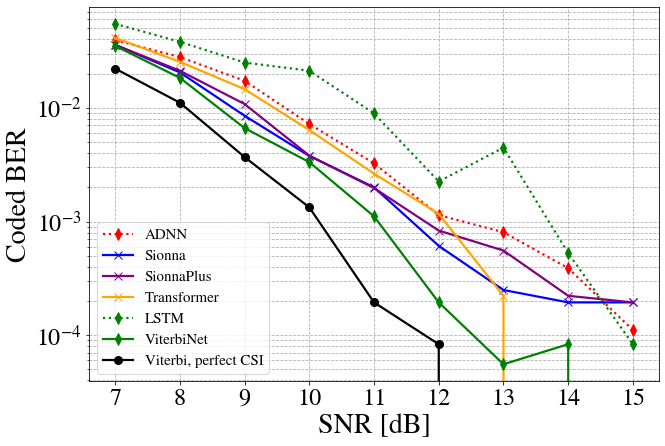

In [ ]:
#@title displaying tabular results
import torch
import numpy as np
import pandas as pd
models_list = ['ADNN', 'Sionna', 'SionnaPlus', 'Transformer','LSTM', 'ViterbiNet']
df = pd.DataFrame(all_curves,columns =['BER', 'NET','InfoBits', 'Modulation'])
#adnn = df[df.NET == 'ADNN']
#model_ber = df[df.NET == model]
#model_ber.index = snr_values
#adnn.mean(axis = 1, skipna = True)
results = np.zeros((len(snr_values),len(models_list)))
i=0
j=0
for snr in snr_values:    
    j=0
    for model in models_list:  
      #print(j)
      model_ber = df[df.NET == model]
      model_ber.index = snr_values
      results[i,j] = model_ber[['BER']].loc[snr].mean(axis = 0, skipna = True).mean()
      j+=1      
    i+=1
res = pd.DataFrame(results,columns=models_list)
res.index = snr_values
print(res)


|SNR     |ADNN	   |Sionna	  |SionnaPlus |Transformer|	LSTM	    |ViterbiNet	|ClassicViterbi
|:--------|:------:|:--------:|:---------:|:---------:|:---------:|:---------:|--------------|		
|7|0.041556|0.037167|0.034194|0.042250|0.049028|0.030667|0.022167|
|8|0.029583|0.020000|0.022917|0.025333|0.036583|0.016833|0.011111|
|9|0.018250|0.010528|0.010833|0.014833|0.029167|0.009222|0.003694|
|10|	0.010528|0.005361|0.006333|0.007944|0.015972|0.004139|0.001333|
|11|	0.004056|0.001778|0.001667|0.002333|0.007694|0.001250|0.000194|
|12|	0.003139|0.001000|0.000333|0.000806|0.003694|0.000444|0.000083|
|13|	0.000611|0.000500|0.000111|0.000083|0.000889|0.000167|0.000000|
|14|	0.000389|0.000167|0.000056|0.000000|0.000917|0.000083|0.000000|
|15|	0.000194|0.000278|0.000000|0.000000|0.000806|0.000083|0.000000|  
